# Modeling Sublimation Event Occurrence

Written by: Daniel Hogan

10 April 2025

It's raining outside with a weak AR-like event impacting northern VI

This notebook will develop, test, and validate a few different model strategies to classify when sublimation events occur using ERA5 reanalysis data.

## Imports

In [1]:
# general
import datetime as dt
import glob
import os
import logging
from typing import Tuple, List
import gc
import joblib
from pathlib import Path

# data 
import xarray as xr 
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import gridspec
import seaborn as sns

# helper tools
from metpy import calc, units
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Data driven modeling 
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
    train_test_split,
    cross_val_predict,
    cross_validate,
    cross_val_score,
    ValidationCurveDisplay,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
import optuna
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from optuna import integration
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

# stats
import shapely.geometry as shp
from itertools import product
from scipy.stats import pearsonr, spearmanr, linregress
from scipy.ndimage import label, find_objects
import pymannkendall as mk
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms


## Data

### Functions

In [2]:
# Function to load and subset ERA5 data
def load_era5_data(pressure_level=500):
    """
    Load and subset ERA5 data based on latitude and longitude selections.
    """
    ds = xr.open_mfdataset('/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_202*.nc')
    ds = ds.sel(pressure_level=pressure_level)
    return ds

def calc_valley_aligned_wind_speed(wind_speed, wind_dir, valley_alignment):
    """
    Calculate the valley aligned wind speed
    """
    # calculate the angle between the wind direction and the valley alignment
    angle = np.abs(wind_dir - valley_alignment)
    # calculate the valley aligned wind speed
    valley_aligned_wind_speed = wind_speed * np.cos(np.radians(angle))
    return valley_aligned_wind_speed

    # Calculate the gradients at 500-mb
def calc_era5_gradients(ds):
    u = ds['u']          # shape: (time, lat, lon)
    v = ds['v']
    temp = ds['t']
    q = ds['q']          # specific humidity
    zeta = ds['vo']      # relative vorticity
    z = ds['z']          # geopotential height

    # Get spatial resolution (assumes regular grid)
    dy = np.deg2rad(ds.latitude.diff('latitude').mean()) * 6371000  # m per degree latitude
    dx = np.deg2rad(ds.longitude.diff('longitude').mean()) * 6371000 * np.cos(np.deg2rad(ds.latitude.mean()))  # m per degree longitude

    # Convert degrees to meters
    Re = 6.371e6  # Earth radius in meters
    lat_rad = np.deg2rad(ds.latitude.diff('latitude'))

    # Calculate dx and dy in meters
    dx = np.deg2rad(ds.longitude.diff('longitude').mean()) * Re * np.cos(np.deg2rad(ds.latitude.mean())).values
    dy = np.abs(np.deg2rad(ds.latitude.diff('latitude').mean()) * Re).values  # m per degree latitude

    # Compute gradients
    dT_dx = (temp.differentiate('longitude') / dx) * 1000 # Convert to K/km
    dT_dy = (temp.differentiate('latitude') / dy) * 1000 # Convert to K/km

    # Compute specific humidity gradients
    dq_dx = (q.differentiate('longitude') / dx) * 1000 # Convert to g/kg/km
    dq_dy = (q.differentiate('latitude') / dy) * 1000 # Convert to g/kg/km

    # Compute relative vorticity gradient
    dZeta_dx = (zeta.differentiate('longitude') / dx) * 1000 # Convert to 1/s/km
    dZeta_dy = (zeta.differentiate('latitude') / dy) * 1000 # Convert to 1/s/km

    # Optionally compute gradient magnitude and advection term
    advection_T = -(u * dT_dx + v * dT_dy)/1000 # units of K/s
    advection_q = -(u * dq_dx + v * dq_dy)/1000 # units of g/kg/s
    advection_zeta = -(u * dZeta_dx + v * dZeta_dy)/1000 # units of 1/s^2

    # convert these to float32
    advection_T = advection_T.astype(np.float32).squeeze()
    advection_q = advection_q.astype(np.float32).squeeze()
    advection_zeta = advection_zeta.astype(np.float32).squeeze()

    # add the advection terms to the dataset
    ds['advection_T'] = (('valid_time', 'latitude', 'longitude'), advection_T.data)
    ds['advection_q'] = (('valid_time', 'latitude', 'longitude'), advection_q.data)
    ds['advection_zeta'] = (('valid_time', 'latitude', 'longitude'), advection_zeta.data)

    return ds

def subset_ds(ds, winter_slice, calc_gradients=True):
    """
    Subset the dataset to the winter months
    """
    # subset the data   
    ds_subset = ds.sel(valid_time=winter_slice)

    # if calc_gradients is True, calculate the gradients of the variables
    if calc_gradients:
        # call the calc_era5_gradients function to calculate the gradients
        ds_subset = calc_era5_gradients(ds_subset)

    # calculate the wind speed and direction
    ds_subset['wind_speed'] = np.sqrt(ds_subset.u**2 + ds_subset.v**2)
    # create a column with the wind direction
    ds_subset['wind_dir'] = np.arctan2(ds_subset['v'], ds_subset['u']) * 180 / np.pi
    # convert wind direction to compass direction
    ds_subset['wind_dir'] = (270 - ds_subset['wind_dir']) % 360

    # calculate "northerliness"
    ds_subset['northerliness'] = np.cos(np.deg2rad(ds_subset['wind_dir']))
    
    # calculate dew point from relative humidity and temeprature
    # convert temperature to celsius
    ds_subset['t'] = units.units('degC') * (ds_subset['t']-273.15)

    # calculate vpd
    ds_subset['vpd'] = calc.saturation_vapor_pressure((ds_subset['t'])) - ds_subset['q'] * units.units('Pa')
    return ds_subset.squeeze()

def spatial_subset(ds, lat_range, lon_range, point=False):
    """
    Subset the dataset to a specific latitude and longitude range.
    """
    if point:
        # If point is True, select the nearest point in the dataset
        ds_subset = ds.sel(latitude=lat_range, longitude=lon_range, method='nearest')
        return ds_subset
    else:
        # if point is False, select the latitude and longitude range
        # if is a slice, use slice
        if isinstance(lat_range, slice) and isinstance(lon_range, slice):
            ds_subset = ds.sel(latitude=lat_range, longitude=lon_range)
        else:
            # If lat_range and lon_range are lists or tuples, use slice
            lat_range = slice(lat_range[0], lat_range[1])
            lon_range = slice(lon_range[0], lon_range[1])
            ds_subset = ds.sel(latitude=lat_range, longitude=lon_range)
        return ds_subset

### ERA5 data

Spatial selection is performed here!! Very important.

In [3]:
# Load the ERA5 data
ds = load_era5_data()

# Define the winter slices for 2022 and 2023
winter_2022 = slice('2021-12-01T00:00:00', '2022-03-31T23:00:00')
winter_2023 = slice('2022-12-01T00:00:00', '2023-03-31T23:00:00')

# Subset the dataset for the winter months and calculate gradients
ds_all_winter_2022 = subset_ds(ds, winter_2022, calc_gradients=True)
ds_all_winter_2023 = subset_ds(ds, winter_2023, calc_gradients=True)

# close the dataset to free up memory
try:
    ds.close()
    ds = None
except Exception as e:
    print(f"Dataset already closed or error closing: {e}")

In [4]:
# geographic data and orietation of the valley
valley_orientation = 305
cross_valley_orientation = 215
# get the coordingates of Grand Junction, CO
gj = shp.Point(-108.5506, 39.0639)
# get the coordinates of Gothic, CO
gothic = shp.Point(-106.9898, 38.9592)
line = shp.LineString([gj, gothic])

# Define the latitude and longitude slices for the region of interest region
lat_sel_5_by_5 = slice(39.5, 38.25)
lon_sel_5_by_5 = slice(-107.5, -106.5)

lat_sel_10_by_10 = slice(40, 37.75)
lon_sel_10_by_10 = slice(-108.75,-106.5)

lat_sel_15_by_15 = slice(40.5, 37)
lon_sel_15_by_15 = slice(-110, -106.5)


# Single grid-cell selection for Gothic, CO
ds_gt_winter_2022 = spatial_subset(ds_all_winter_2022, gothic.y, gothic.x,  point=True)
ds_gt_winter_2023 = spatial_subset(ds_all_winter_2023, gothic.y, gothic.x, point=True)

# 5 by 5 degree selection
ds_5_by_5_winter_2022 = spatial_subset(ds_all_winter_2022, lat_sel_5_by_5, lon_sel_5_by_5).mean(dim=['latitude', 'longitude'])
ds_5_by_5_winter_2023 = spatial_subset(ds_all_winter_2023, lat_sel_5_by_5, lon_sel_5_by_5).mean(dim=['latitude', 'longitude'])

# 10 by 10 degree selection
ds_10_by_10_winter_2022 = spatial_subset(ds_all_winter_2022, lat_sel_10_by_10, lon_sel_10_by_10).mean(dim=['latitude', 'longitude'])
ds_10_by_10_winter_2023 = spatial_subset(ds_all_winter_2023, lat_sel_10_by_10, lon_sel_10_by_10).mean(dim=['latitude', 'longitude'])

# 15 by 15 degree selection
ds_15_by_15_winter_2022 = spatial_subset(ds_all_winter_2022, lat_sel_15_by_15, lon_sel_15_by_15).mean(dim=['latitude', 'longitude'])
ds_15_by_15_winter_2023 = spatial_subset(ds_all_winter_2023, lat_sel_15_by_15, lon_sel_15_by_15).mean(dim=['latitude', 'longitude'])


In [5]:
# close the datasets to free up memory
try:
    ds_all_winter_2022.close()
    ds_all_winter_2022 = None
except Exception as e:
    print(f"Dataset already closed or error closing: {e}")

try:
    ds_all_winter_2023.close()
    ds_all_winter_2023 = None
except Exception as e:
    print(f"Dataset already closed or error closing: {e}")

### Latent heat flux data

In [6]:
# take in sublimation data
latent_heat_flux_2022 = pd.read_csv('./01_data/processed_data/sublimation/w22_latent_heat_flux_splash_ap.csv', index_col=0, parse_dates=True)
latent_heat_flux_2023 = pd.read_csv('./01_data/processed_data/sublimation/w23_latent_heat_flux_3m.csv', index_col=0, parse_dates=True)

### Event classifications

In [7]:
# open large and short events dataset 
w22_large_sublimation_long_events = pd.read_csv('./01_data/processed_data/sublimation/w22_long_evts.csv', index_col=0, parse_dates=True)
w22_large_sublimation_short_events = pd.read_csv('./01_data/processed_data/sublimation/w22_spiky_evts.csv', index_col=0, parse_dates=True)
w23_large_sublimation_long_events = pd.read_csv('./01_data/processed_data/sublimation/w23_long_evts.csv', index_col=0, parse_dates=True)
w23_large_sublimation_short_events = pd.read_csv('./01_data/processed_data/sublimation/w23_spiky_evts.csv', index_col=0, parse_dates=True)

### Precipitation data (from Gothic weighing bucket)

In [8]:
# open precipitation data
w22_precipitation = pd.read_csv('./01_data/processed_data/precipitation/w22_all_precip_30min.csv', index_col=0, parse_dates=True)['SAIL_gts_pluvio'].loc['2021-12-01':'2022-03-31']
w23_precipitation = pd.read_csv('./01_data/processed_data/precipitation/w23_all_precip_30min.csv', index_col=0, parse_dates=True)['SAIL_gts_pluvio'].loc['2022-12-01':'2023-03-31']

### Long term observations

#### GJT sounding 500-mb winds

In [9]:
# observations from GUC sounding
guc_obs = pd.read_csv('./01_data/processed_data/winter_500mb_GUC_winds.csv', index_col=0)

#### Long-term Dec-Mar precipitation from billy barr

In [10]:
# open from data folder
bb_prcp = pd.read_csv('./01_data/processed_data/precipitation/billy_barr_total_monthly_P.csv', delimiter='\s+', index_col=0)

# filter to Dec-Mar
winter_bb_prcp = bb_prcp[['Dec', 'Jan', 'Feb', 'Mar']]

## Data Processing

### Functions

In [11]:
def compute_cross_correlation(df, target_var, lag_range=(-10, 10)):
    """
    Compute cross-correlations between a target variable and other variables with different time lags.

    Parameters:
    - df: pandas DataFrame with time-indexed meteorological variables.
    - target_var: Name of the target variable (e.g., "sublimation").
    - lag_range: Tuple specifying min and max lag (e.g., (-10, 10)).

    Returns:
    - A DataFrame containing cross-correlations for each lag.
    """
    variables = df.columns.drop(target_var)  # Exclude the target variable itself
    lag_values = range(lag_range[0], lag_range[1] + 1)

    correlation_results = pd.DataFrame(index=lag_values, columns=variables)

    for lag in lag_values:
        shifted_target = df[target_var].shift(lag)  # Shift target variable
        correlation_results.loc[lag] = df[variables].corrwith(shifted_target)

    return correlation_results.astype(float)

def find_best_synoptic_variable(surface_obs, synoptic_data, method='pearson'):
    """
    Finds the synoptic-scale variable that is most closely related to a given surface meteorology observation.

    Parameters:
    - surface_obs (pd.Series): Time series of the surface meteorology variable (e.g., temperature, humidity).
    - synoptic_data (pd.DataFrame): Time series of synoptic-scale variables (e.g., geopotential height, wind speed).
    - method (str): Correlation method ('pearson' for linear, 'spearman' for rank-based). Default is 'pearson'.

    Returns:
    - dict: Contains the best-correlated variable, its correlation coefficient, and the full correlation results.
    """
    
    correlations = {}

    for var in synoptic_data.columns:
        synoptic_var = synoptic_data[var]

        # Drop NaN values
        valid_idx = surface_obs.index.intersection(synoptic_var.dropna().index)
        x = surface_obs.loc[valid_idx]
        y = synoptic_var.loc[valid_idx]

        if len(x) < 10:  # Require a minimum number of valid data points
            continue

        # Compute correlation
        if method == 'pearson':
            corr, _ = pearsonr(x, y)
        elif method == 'spearman':
            corr, _ = spearmanr(x, y)
        else:
            raise ValueError("Invalid method. Choose 'pearson' or 'spearman'.")

        correlations[var] = corr

    # Find the variable with the highest absolute correlation
    best_var = max(correlations, key=lambda k: abs(correlations[k]))
    
    return {
        'best_variable': best_var,
        'best_correlation': correlations[best_var],
        'all_correlations': correlations
    }

def select_data(lh_df, ppt_data, reanalysis_ds, short_events, long_events):
    """
    This function will provide the necessary data for the analysis of sublimation events in relation to the reanalysis data.
    """
    # resample latent heat flux data and precipitation data to 3H
    lh_df_3H = lh_df.resample('3H').mean()
    ppt_data_3H = ppt_data.resample('3H').sum()
    #   filter out exrtreme values
    lh_df_3H = lh_df_3H.where(lh_df_3H >-50, np.nan)
    # select the reanalysis pressure level
    ds = reanalysis_ds.resample(valid_time='3H').mean()

    return lh_df_3H, ppt_data_3H, ds, short_events, long_events

# Plotting 
def plot_surface_and_reanalysis_vars(lh_df, ppt_data, era5_ds, short_events, long_events, lh_var, reanalysis_var1, reanalysis_var2):
    """
    This function will plot the relationship between the latent heat flux and the reanalysis variables.
    Inputs:
    lh_df: DataFrame with the latent heat flux data
    ppt_data: DataFrame with the precipitation data
    era5_ds: xarray dataset with the reanalysis data
    short_events: DataFrame with the short, intense sublimation events
    long_events: DataFrame with the long sublimation events
    lh_var: string with the name of the latent heat flux variable
    reanalysis_var1: string with the name of the first reanalysis variable
    reanalysis_var2: string with the name of the second reanalysis variable
    """
    lh_df, ppt_data, era5_ds, short_events, long_events = select_data(lh_df, ppt_data, era5_ds, short_events, long_events)

    xlabel_dict = {'u': 'Wind Speed (m/s)', 
                   'v': 'Wind Speed (m/s)', 
                   't': 'Temperature (C)', 
                   'q': 'Specifc Humidity (kg/kg)', 
                   'wind_speed': 'Wind Speed (m/s)', 
                   'wind_dir': 'Wind Direction (degrees)',
                   'northerliness': 'Index of how northerly wind is (+1 strong north wind, -1 strong south wind)',
                   }
    xlims_dict = {
             'q': (0, 0.0035),
             't': (-40, -5),}
             
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    ax = axs[0]
    ax.scatter(era5_ds[reanalysis_var1], lh_df[lh_var])
    # ax.set_xlabel('Wind Speed')
    ax.set_ylabel('Daily Average Latent Heat Flux (W/m^2)')
    if reanalysis_var1 in xlims_dict.keys():
            ax.set_xlim(xlims_dict[reanalysis_var1])

    # add edge color around the large sublimation events 
    ax.scatter(era5_ds.sel(valid_time=long_events.index)[reanalysis_var1], lh_df.loc[long_events.index][lh_var], c="black", edgecolors='black')
    ax.scatter(era5_ds.sel(valid_time=ppt_data[ppt_data>1].index)[reanalysis_var1], lh_df.loc[ppt_data[ppt_data>1].index][lh_var], c="red", edgecolors='red', label='Precipitation')
    ax.set_xlabel(xlabel_dict[reanalysis_var1])
    ax.axvline(28, color='black', linestyle='--')
    
    ax = axs[1]
    ax.scatter(era5_ds[reanalysis_var2], lh_df[lh_var])
    ax.scatter(era5_ds.sel(valid_time=long_events.index)[reanalysis_var2], lh_df.loc[long_events.index][lh_var], c="black", edgecolors='black', label='Long Events')
    ax.axvline(33, color='black', linestyle='--')
    ax.scatter(era5_ds.sel(valid_time=ppt_data[ppt_data>1].index)[reanalysis_var2], lh_df.loc[ppt_data[ppt_data>1].index][lh_var], c="red", edgecolors='red', label='Precipitation')
    ax.set_xlabel(xlabel_dict[reanalysis_var2])
    ax.set_ylabel('Daily Average Latent Heat Flux (W/m^2)')
    ax.legend()
    if reanalysis_var2 in xlims_dict.keys():
            ax.set_xlim(xlims_dict[reanalysis_var2])
    # add colorbar
    # plt.colorbar(ax.collections[0], ax=axs, orientation='horizontal', label='500 mb Temperature (C)')

    for ax in axs:
        ax.set_ylim(-10, lh_df[lh_var].max()+10)
    return fig

In [12]:
def add_events_col(df, 
                   short_events, 
                   long_events):
    """
    This function will add a column to the dataframe indicating whether the event is a short or long event.
    """
    # add event column, but only for the long sublimation events
    df['event'] = 0
    if long_events is not None:
        df.loc[long_events, 'event'] = 1
    else:
        print("No long events provided.")
    if short_events is not None:
        df.loc[short_events, 'event'] = 1
    else:
        print("No short events provided.")
    return df

def create_df_combined(ds1, ds2, variables, resample=True, vars_to_add=None, add_events=True):
    # merge datasets
    ds_combined = xr.merge([ds1, ds2])

    # convert to dataframe
    df_combined = ds_combined[variables].to_dataframe()[variables]

    # if vars_to_add is not None, add the key as the name and the value as the value
    if vars_to_add is not None:
        for key, value in vars_to_add.items():
            if key == "latent_heat_flux":
                # if the value is a dataframe, resample to 3H and take the mean
                if isinstance(value, pd.DataFrame):
                    df_combined = pd.merge(value, df_combined, left_index=True, right_index=True)
                else:
                    print(f"{key} is not a dataframe. Make sure it is.")
            else:
                df_combined[key] = value
    # if resample is True, resample to 3H and take the mean
    if isinstance(resample, bool) and resample:
        df_combined = df_combined.resample('3H').mean()
        # if add_events is True, add the events column
        if add_events:
            # add event column
            df_combined = add_events_col(df_combined, 
                                        short_events=None, 
                                        long_events=pd.concat([w22_large_sublimation_long_events,
                                                                w23_large_sublimation_long_events]).index)
    elif isinstance(resample, str):
        df_combined = df_combined.resample('3H').mean()
        if add_events:
            df_combined = add_events_col(df_combined, 
                                        short_events=None, 
                                        long_events=pd.concat([w22_large_sublimation_long_events,
                                                                w23_large_sublimation_long_events]).index)
            df_combined = df_combined.resample(resample).agg({'sublimation': 'sum', 
                                                                'u': 'mean', 
                                                                'v': 'mean', 
                                                                't': 'mean',
                                                                'q' : 'min',
                                                                'vpd': 'min',
                                                                'wind_speed': 'max', 
                                                                'precipitation':'sum',
                                                                'advection_T': 'mean',
                                                                'advection_q': 'mean',
                                                                'advection_zeta': 'mean', 
                                                                'event': 'max'})
        else: 
            df_combined = df_combined.resample(resample).agg({  'u': 'mean', 
                                                                'v': 'mean', 
                                                                't': 'mean',
                                                                'q' : 'min',
                                                                'vpd': 'min',
                                                                'wind_speed': 'max', 
                                                                'precipitation':'sum',
                                                                'advection_T': 'mean',
                                                                'advection_q': 'mean',
                                                                'advection_zeta': 'mean'})
    # reset the index and dropna
    df_combined = df_combined.reset_index()
    # if event is in the columns
    if 'event' in df_combined.columns:
        # replace event values equal to 0 with "non-event" and 1 with "event"
        df_combined['event'] = df_combined['event'].replace({0: 'non-event', 1: 'event'})
    else:
        print("No event column found.")
     
    return df_combined


### Latent Heat Data

In [13]:
# 2022
if 'splash_ap' in latent_heat_flux_2022.columns:
    latent_heat_flux_2022.rename(columns={'splash_ap': 'sublimation'}, inplace=True)
# 2023
if 'sos_3m' in latent_heat_flux_2023.columns:
    latent_heat_flux_2023.rename(columns={'sos_3m': 'sublimation'}, inplace=True)
# combine the latent heat flux data
latent_heat_flux = pd.concat([latent_heat_flux_2022, latent_heat_flux_2023], axis=0)

### Precipitation

In [14]:
# add precipitation
precip_df = pd.concat([w22_precipitation, w23_precipitation], axis=0).resample('3H').sum()

### Combine Datasets

In [15]:
selected_datasets = [ds_10_by_10_winter_2022, ds_10_by_10_winter_2023]
variables = ['t', 'wind_speed','vpd', 'u','v','q','advection_T', 'advection_q', 'advection_zeta']
# merge the two datasets
combined_df = create_df_combined(selected_datasets[0], 
                                 selected_datasets[1], 
                                 variables, 
                                 resample=True, 
                                 vars_to_add={'precipitation': precip_df,
                                              'latent_heat_flux': latent_heat_flux})

No short events provided.


In [16]:
combined_df_12H = create_df_combined(selected_datasets[0],
                                      selected_datasets[1], 
                                      variables, 
                                      resample='12H', 
                                      vars_to_add={'precipitation': precip_df,
                                              'latent_heat_flux': latent_heat_flux})

No short events provided.


### Basic Statistics

#### Calculate correlations between variables
*Note: Can adjust easily for 2023, but we see similar results.*

In [17]:
# Here, we use just the ERA5 grid-cell directly over Gothic
lh_df, ppt_data, era5_ds, short_events, long_events = select_data(latent_heat_flux_2023, 
                                                                  w23_precipitation, 
                                                                  ds_10_by_10_winter_2023, 
                                                                  w23_large_sublimation_short_events, 
                                                                  w23_large_sublimation_long_events,)

In [18]:
# largest_events = (long_events.groupby('event').mean() > 15)
synoptic_data = era5_ds.to_dataframe()[variables].loc[[t[0] for t in long_events.groupby('event_number').idxmax().values]]
surface_obs = long_events.groupby('event_number').max().set_index(synoptic_data.index).value

result = find_best_synoptic_variable(surface_obs, synoptic_data, method='spearman')

print("Best correlated synoptic variable:", result['best_variable'])
for var, corr in result['all_correlations'].items():
    print(f"{var}: {corr:.2f}")

Best correlated synoptic variable: q
t: 0.05
wind_speed: 0.42
vpd: 0.12
u: 0.30
v: -0.22
q: -0.48
advection_T: 0.10
advection_q: -0.16
advection_zeta: -0.19


Calculate correlations between variables using average of all grids

In [23]:
# Calculate correlations between variables using average of all grids
lh_df, ppt_data, era5_ds, short_events, long_events = select_data(latent_heat_flux_2022, 
                                                                  w22_precipitation, 
                                                                  ds_10_by_10_winter_2022, 
                                                                  w22_large_sublimation_short_events, 
                                                                  w22_large_sublimation_long_events,)

In [24]:
# largest_events = (long_events.groupby('event').mean() > 15)
synoptic_data = era5_ds.to_dataframe()[variables].loc[[t[0] for t in long_events.groupby('event_number').idxmax().values]]
surface_obs = long_events.groupby('event_number').max().set_index(synoptic_data.index).value

result = find_best_synoptic_variable(surface_obs, synoptic_data, method='spearman')

print("Best correlated synoptic variable:", result['best_variable'])
for var, corr in result['all_correlations'].items():
    print(f"{var}: {corr:.2f}")

Best correlated synoptic variable: t
t: 0.29
wind_speed: 0.17
vpd: 0.29
u: -0.12
v: -0.27
q: -0.12
advection_T: -0.21
advection_q: -0.04
advection_zeta: 0.11


Discussion:

We averaged the synoptic level (500 mb) data in two differnt ways: the average of a 10x10 ERA5 grid centered over the East River valley and the nearest grid cell over Gothic. We took this data and calculated spearman correlations with the maximum surface latent heat flux observation during long events. 

We found that both the single grid cell and the regional average both correlate well with u-wind and wind-speed. However, large differences are observed for temperature (> for single grid cell), vorticity (> for grid-average)

This likely means that including certain variables may not be super helpful. This is only for the 2023 data.

We get a pretty different story during 2022. For the gridded average, v, q, and t have the largest relationships, with wind speed being much lower. This might be why including these other variables prove to be useful within the model. It seems q, t, u, v, and vo are the most useful. 

#### Percentile rank figures

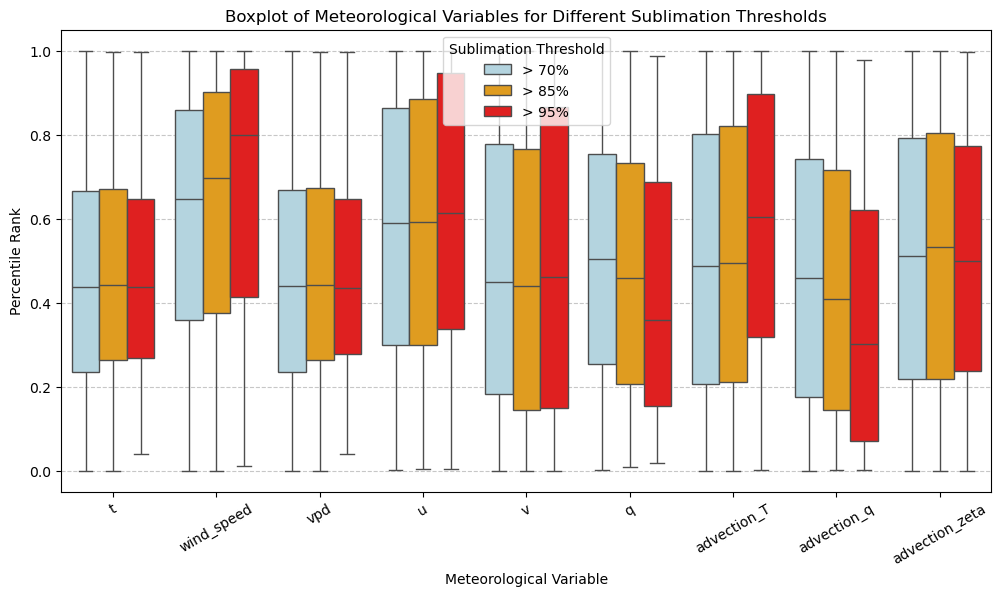

In [25]:
# Calculate percentiles
percentiles = combined_df.rank(method="average", pct=True)[['t', 'wind_speed','vpd', 'u','v','q','advection_T', 'advection_q', 'advection_zeta','sublimation']]

# Subset for different sublimation thresholds
percentiles_sub_50 = percentiles[percentiles['sublimation'] > 0.75]
percentiles_sub_75 = percentiles[percentiles['sublimation'] > 0.85]
percentiles_sub_95 = percentiles[percentiles['sublimation'] > 0.95]

# Drop 'sublimation' since it's the target variable
variables = ['t', 'wind_speed','vpd', 'u','v','q','advection_T', 'advection_q', 'advection_zeta']

# Create a grouped DataFrame for boxplot
melted_50 = percentiles_sub_50[variables].melt(var_name="Variable", value_name="Percentile")
melted_50["Threshold"] = "> 70%"

melted_75 = percentiles_sub_75[variables].melt(var_name="Variable", value_name="Percentile")
melted_75["Threshold"] = "> 85%"

melted_95 = percentiles_sub_95[variables].melt(var_name="Variable", value_name="Percentile")
melted_95["Threshold"] = "> 95%"

# Combine into a single dataframe
plot_data = pd.concat([melted_50, melted_75, melted_95])

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variable", y="Percentile", hue="Threshold", data=plot_data, palette=["lightblue", "orange", "red"])

# Customization
plt.title("Boxplot of Meteorological Variables for Different Sublimation Thresholds")
plt.xlabel("Meteorological Variable")
plt.ylabel("Percentile Rank")
plt.legend(title="Sublimation Threshold", loc='upper center')
plt.xticks(rotation=30)  # Rotate x labels for better readability

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


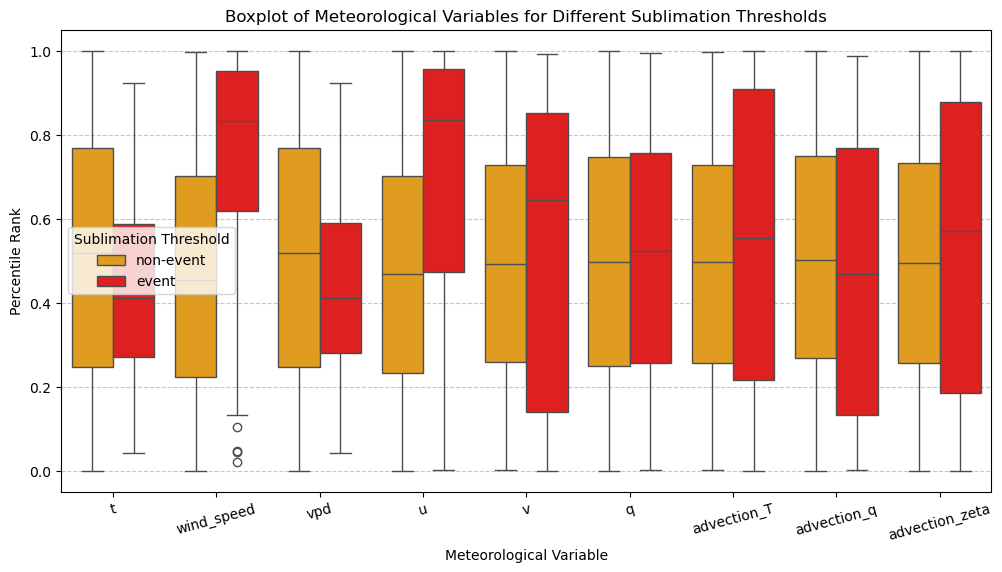

In [26]:
# Calculate percentiles
percentiles = combined_df.rank(method="average", pct=True)[['t', 'wind_speed','vpd', 'u','v','q','advection_T', 'advection_q', 'advection_zeta','sublimation']]

# Subset for different sublimation thresholds
percentiles_event = percentiles[combined_df['event']=='event']
percentiles_non_event = percentiles[combined_df['event']=='non-event']

# Drop 'sublimation' since it's the target variable
variables = ['t', 'wind_speed','vpd', 'u','v','q','advection_T', 'advection_q', 'advection_zeta']

# Create a grouped DataFrame for boxplot
melted_non_event = percentiles_non_event[variables].melt(var_name="Variable", value_name="Percentile")
melted_non_event["Threshold"] = "non-event"

melted_event = percentiles_event[variables].melt(var_name="Variable", value_name="Percentile")
melted_event["Threshold"] = "event"

# Combine into a single dataframe
plot_data = pd.concat([melted_non_event, melted_event]).reset_index(drop=True)

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variable", y="Percentile", hue="Threshold", data=plot_data, palette=["orange", "red"])

# Customization
plt.title("Boxplot of Meteorological Variables for Different Sublimation Thresholds")
plt.xlabel("Meteorological Variable")
plt.ylabel("Percentile Rank")
plt.legend(title="Sublimation Threshold")
plt.xticks(rotation=15)  # Rotate x labels for better readability

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### Temporal cross-correlation figures
When are variables cross correlated with high sublimation rates?

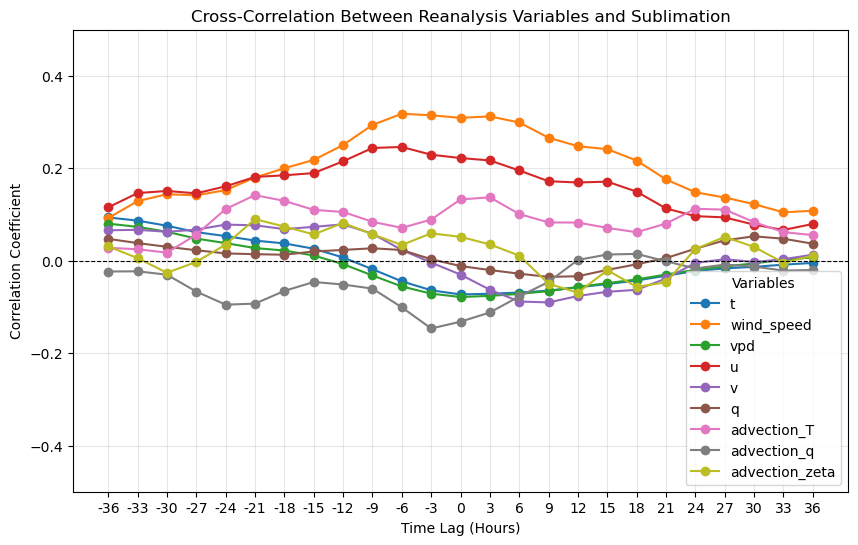

In [27]:
# Example usage
cross_corrs = compute_cross_correlation(combined_df[['t', 'wind_speed','vpd', 'u','v','q','advection_T', 'advection_q', 'advection_zeta','sublimation']], 
                                        target_var='sublimation', 
                                        lag_range=(-12, 12))

# Plot correlation results
plt.figure(figsize=(10, 6))
for var in cross_corrs.columns:
    plt.plot(cross_corrs.index, cross_corrs[var], label=var, marker='o', linestyle='-')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Reference line at 0
# change out the x-axis for hours by multiplying by 3
plt.xticks(np.arange(-12, 13, 1), labels=np.arange(-12, 13, 1)*3)
plt.xlabel("Time Lag (Hours)")
plt.ylabel("Correlation Coefficient")
plt.title("Cross-Correlation Between Reanalysis Variables and Sublimation")
plt.legend(title="Variables")
plt.grid(alpha=0.3)
plt.ylim(-0.5,0.5)
plt.show()


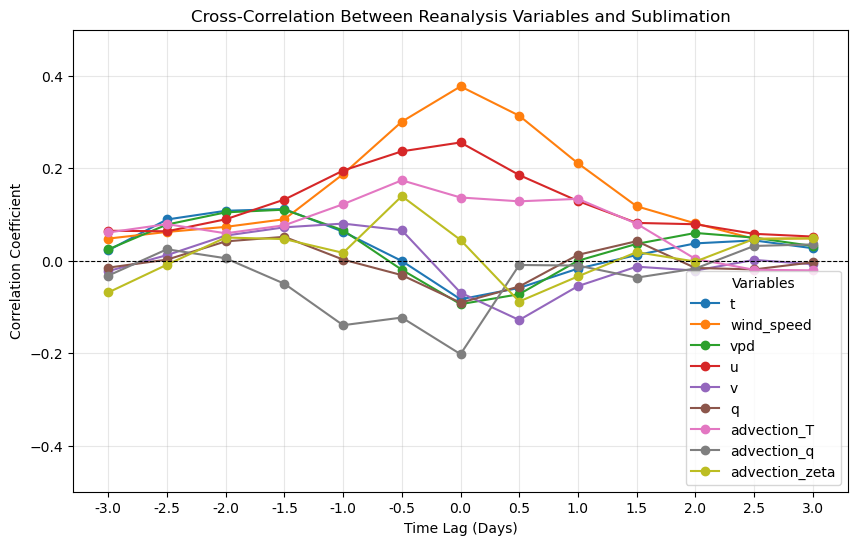

In [28]:
# Example usage
cross_corrs = compute_cross_correlation(combined_df_12H[['t', 'wind_speed','vpd', 'u','v','q','advection_T', 'advection_q', 'advection_zeta','sublimation']], 
                                        target_var='sublimation', 
                                        lag_range=(-6, 6))

# Plot correlation results
plt.figure(figsize=(10, 6))
for var in cross_corrs.columns:
    plt.plot(cross_corrs.index, cross_corrs[var], label=var, marker='o', linestyle='-')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Reference line at 0
# change out the x-axis for hours by multiplying by 3
plt.xticks(np.arange(-6, 7, 1), labels=np.arange(-6, 7, 1)/2)
plt.xlabel("Time Lag (Days)")
plt.ylabel("Correlation Coefficient")
plt.title("Cross-Correlation Between Reanalysis Variables and Sublimation")
plt.legend(title="Variables")
plt.grid(alpha=0.3)
plt.ylim(-0.5,0.5)
plt.show()


#### Histograms of each variable

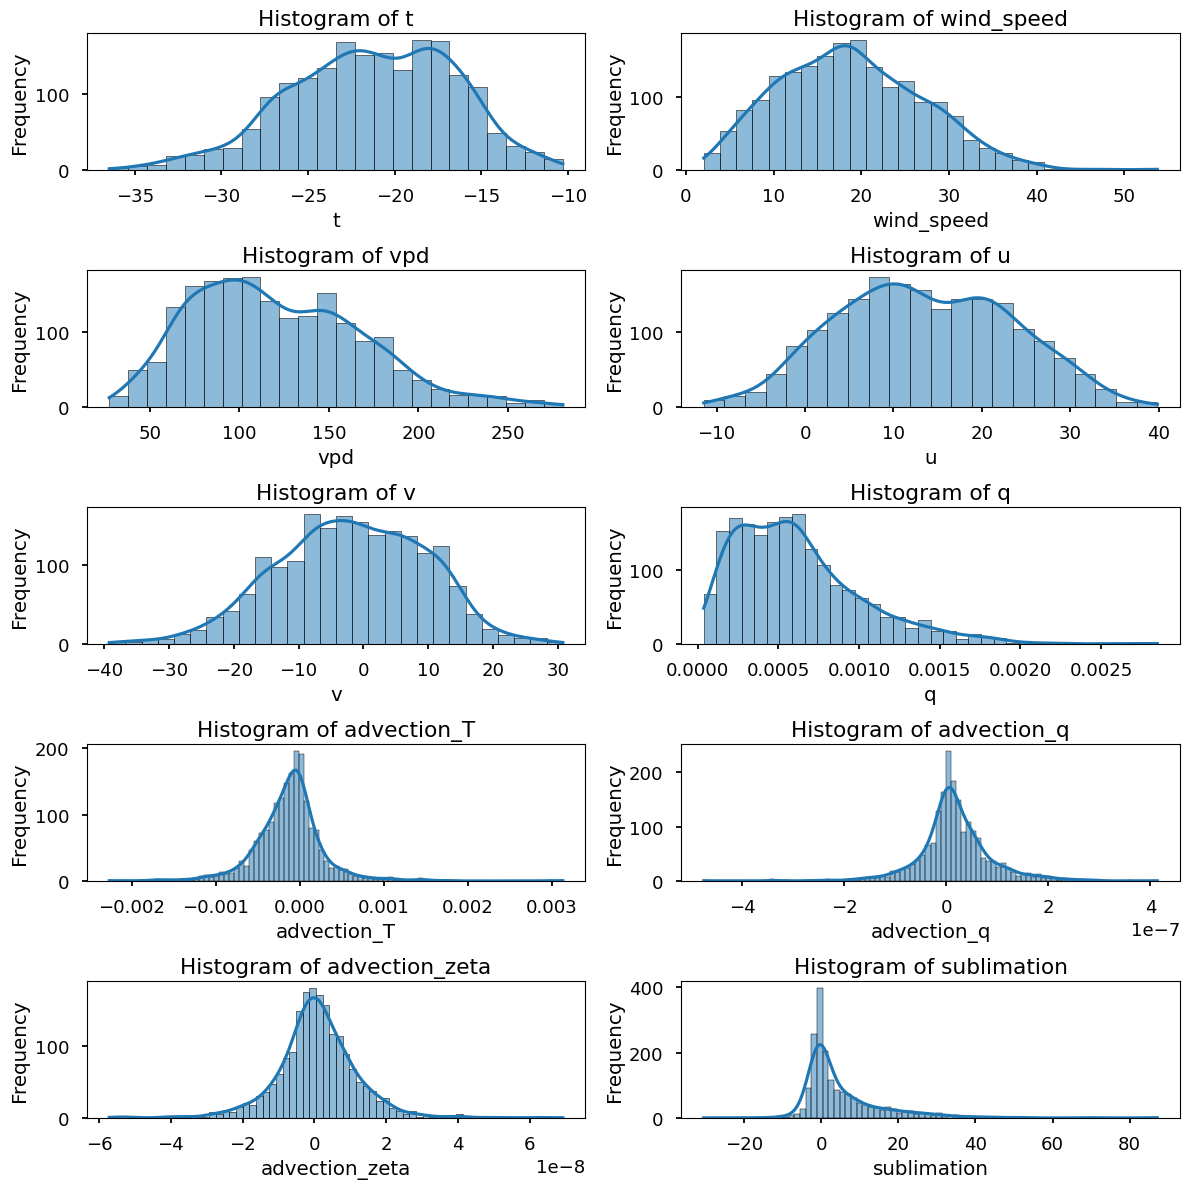

In [98]:
vars_to_plot = ['t', 'wind_speed','vpd', 'u','v','q','advection_T', 'advection_q', 'advection_zeta','sublimation']

# plot histograms of each variable in vars_to_plot
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
for ax, var in zip(axs.flat, vars_to_plot):
    sns.histplot(combined_df[var], ax=ax, kde=True)
    ax.set_title(f"Histogram of {var}")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
plt.tight_layout()

#### Event frequency relative to all 3H observations

/tmp/ipykernel_16171/3431376493.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Event", "Event"])


[Text(0, 0, 'Non-Event'), Text(1, 0, 'Event')]

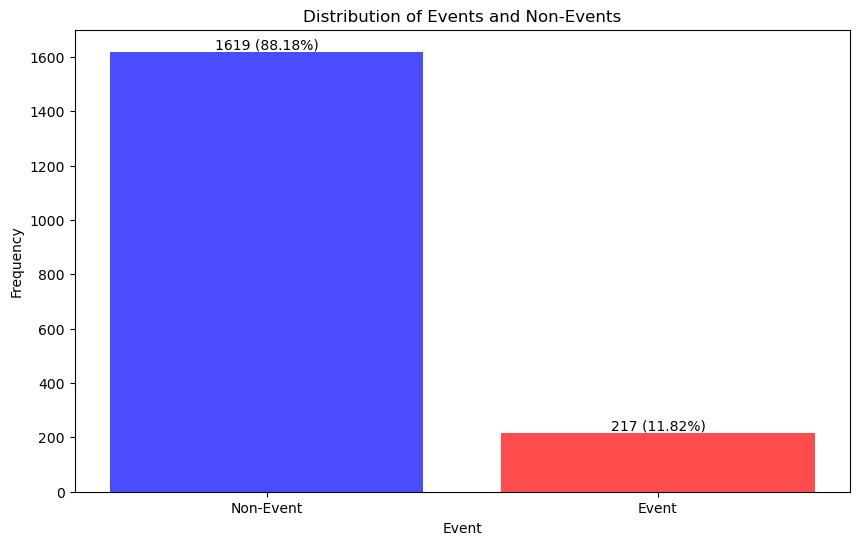

In [29]:
# create distribution of events and non-events
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(combined_df.dropna(how='any')['event'].value_counts().index, combined_df.dropna(how='any')['event'].value_counts().values, color=['blue', 'red'], alpha=0.7)
# add percentage of events and non-events
for i, count in enumerate(combined_df.dropna(how='any')['event'].value_counts().values):
    ax.text(i, count, f"{count} ({count/combined_df.dropna(how='any').shape[0]*100:.2f}%)", ha='center', va='bottom')
ax.set_title("Distribution of Events and Non-Events")
ax.set_xlabel("Event")
ax.set_ylabel("Frequency")
ax.set_xticklabels(["Non-Event", "Event"])

## Modeling

In [30]:
# Set up logging to save results in the specified directory
log_dir = '/home/dlhogan/GitHub/Synoptic-Sublimation/03_results/model_logs'
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, 'model_results.log')
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(message)s')

### Functions

In [68]:
# ------------------------------------------------------------------
# helpers
# ------------------------------------------------------------------
def split_train_test(X, y, test_size=0.2, seed=42):
    return train_test_split(X, y, test_size=test_size,
                            random_state=seed, stratify=y)

def shrink_space(best, pct=0.2):
    """Narrow a numeric param space ±pct around Optuna’s best."""
    out = {}
    for k, v in best.items():
        if isinstance(v, (int, float)):
            delta = pct * v if v != 0 else pct
            lo, hi = v - delta, v + delta
            out[k] = (max(lo, 1e-6), hi) if isinstance(v, float) else (int(lo), int(hi))
    return out

# ------------------------------------------------------------------
# train / evaluate
# ------------------------------------------------------------------
def train_and_evaluate(
    model, name,
    X_tr, y_tr, X_val, y_val,
    search="optuna", param_grid=None, n_trials=100,
    plot=True
):
    ratio = (y_tr == 0).sum() / (y_tr == 1).sum()
    cv    = StratifiedKFold(10, shuffle=True, random_state=42)

    # --------------------------------------------------------------
    # build Optuna search space
    # --------------------------------------------------------------
    def suggest_params(trial):
        if isinstance(model, LogisticRegression):
            C  = trial.suggest_float("C", 1e-4, 1e2, log=True)
            return {
                    "clf__C":       trial.suggest_float("C", 1e-4, 1e2, log=True),
                    "clf__penalty": "l2",                 # fixed or suggest_categorical(...)
                }
        elif isinstance(model, RandomForestClassifier):
            return dict(
                        n_estimators       = trial.suggest_int("n_estimators", 80, 200, step=20),
                        max_depth          = trial.suggest_int("max_depth", 1, 18),   # 0 → None
                        min_samples_split  = trial.suggest_int("min_samples_split", 2, 4),
                        min_samples_leaf   = trial.suggest_int("min_samples_leaf", 2, 4),
                        max_features       = trial.suggest_float("max_features", 0.30, 0.50),
                        bootstrap          = trial.suggest_categorical("bootstrap", [True, False]),
                        class_weight       = {0: 0.1, 1: 0.9},
                    )
        elif isinstance(model, XGBClassifier):
                        return dict(
                    max_depth        = trial.suggest_int(  "max_depth",        7, 11),
                    min_child_weight = trial.suggest_int(  "min_child_weight", 6, 10),
                    gamma            = trial.suggest_float("gamma",            1.0, 3.5),
                    subsample        = trial.suggest_float("subsample",        0.80, 0.90),
                    colsample_bytree = trial.suggest_float("colsample_bytree", 0.65, 0.85),
                    learning_rate    = trial.suggest_float("learning_rate",    0.05, 0.18, log=True),
                    n_estimators     = trial.suggest_int(  "n_estimators",     250, 600, step=50),
                    reg_alpha        = trial.suggest_float("reg_alpha",        0.1, 0.7),
                    reg_lambda       = trial.suggest_float("reg_lambda",       1.0, 5.0),
                    scale_pos_weight = trial.suggest_float("scale_pos_weight",
                                                        0.85*ratio, 1.15*ratio),
                )
        else:
            raise ValueError("No search space defined")

    # --------------------------------------------------------------
    # Optuna search
    # --------------------------------------------------------------
    if search == "optuna":
        pruner  = MedianPruner(n_warmup_steps=25)
        study   = optuna.create_study(direction="maximize",
                                      sampler=TPESampler(n_startup_trials=30,
                                                         multivariate=True),
                                      pruner=pruner)

        def objective(trial):
            params = suggest_params(trial)
            # build model / pipeline
            if isinstance(model, LogisticRegression):
                pipe = Pipeline([
                    ("sc", StandardScaler()),
                    ("clf", LogisticRegression(max_iter=1000, penalty="l2"))
                ])
                pipe.set_params(**params)
                clf = pipe
            else:
                clf = model.__class__(**{**model.get_params(), **params})

            # pruning for XGB
            callbacks = []
            if isinstance(clf, XGBClassifier):
                callbacks = [optuna.integration.XGBoostPruningCallback(trial, "validation_0-logloss")]

            return  cross_val_score(clf, X_tr, y_tr,
                                   cv=cv, scoring="f1").mean()

        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        best_params = study.best_params
        logging.info(f"Best Optuna params: {best_params}")

        # Optionally run a 2‑nd stage narrow search
        narrow = shrink_space(best_params, .15)

        # rebuild final model
        if isinstance(model, LogisticRegression):
            final = LogisticRegression(max_iter=1000, penalty="l2", **best_params)
        else:
            final = model.__class__(**{**model.get_params(), **best_params})
    else:
        final = model

    # --------------------------------------------------------------
    # fit and predict
    # --------------------------------------------------------------
    final.fit(X_tr, y_tr)
    proba = final.predict_proba(X_val)[:, 1]
    pred  = final.predict(X_val)

    f1   = metrics.f1_score(y_val, pred)
    ap   = metrics.average_precision_score(y_val, proba)
    auc  = metrics.roc_auc_score(y_val, proba)

    logging.info(f"{name} | F1={f1:.4f}  AP={ap:.4f}  ROC-AUC={auc:.4f}")

    # -------------------------------------------------------------- plots
    if plot:
        metrics.ConfusionMatrixDisplay.from_estimator(
            final, X_val, y_val, cmap="Blues",
            display_labels=["non‑event", "event"], colorbar=False)
        plt.title(f"{name} – Confusion")
        plt.show()

        # feature importance (trees / LR)
        if hasattr(final, "feature_importances_") or hasattr(final, "coef_"):
            imp = (final.feature_importances_
                   if hasattr(final, "feature_importances_")
                   else np.abs(final.coef_.ravel()))
            names = (X_tr.columns if hasattr(X_tr, "columns")
                     else [f"f{i}" for i in range(len(imp))])
            idx   = np.argsort(imp)[::-1][:20]
            plt.barh(range(len(idx)), imp[idx][::-1])
            plt.yticks(range(len(idx)), np.array(names)[idx][::-1])
            plt.xlabel("Importance")
            plt.title(f"{name} – top features")
            plt.tight_layout(); plt.show()

    return dict(model=final, f1=f1, ap=ap, auc=auc,
                best_params=best_params if search == "optuna" else None)

### Train/Test/Validation Split

Very important, check test size

In [ ]:
test_size = 0.1
# Establish model select variables that will be used to train the model.
selected_datasets = [ds_10_by_10_winter_2022, 
                     ds_10_by_10_winter_2023]
model_variables = ['t', 'wind_speed','vpd', 'u','v','q','advection_T', 'advection_q', 'advection_zeta']
# merge the two datasets
combined_df = create_df_combined(selected_datasets[0], 
                                 selected_datasets[1], 
                                 variables, 
                                 resample=True, 
                                 vars_to_add={'precipitation': precip_df,
                                              'latent_heat_flux': latent_heat_flux})

data_X = combined_df[combined_df['index'].dt.month.isin([12, 1, 2, 3])].dropna(how='any')[model_variables]
data_y = combined_df[combined_df['index'].dt.month.isin([12, 1, 2, 3])].dropna(how='any')['event'].replace({'non-event': 0, 'event': 1})    

X_train, X_val, y_train, y_val = split_train_test(data_X, data_y, test_size=test_size)

No short events provided.


#### Setup for single variable logistic regression.

In [48]:
# Establish model select variables that will be used to train the model.
single_model_variables = ['wind_speed']

data_X_single = combined_df[combined_df['index'].dt.month.isin([12, 1, 2, 3])].dropna(how='any')[single_model_variables]
data_y_single = combined_df[combined_df['index'].dt.month.isin([12, 1, 2, 3])].dropna(how='any')['event'].replace({'non-event': 0, 'event': 1})    

X_train_single, X_val_single, y_train_single, y_val_single = split_train_test(data_X_single, data_y_single, test_size=test_size)

### Training and Cross-Validation
Ceate cross-validation object consisting of 10 folds using stratified sampling and shufffle given that this is a binary classification problem. A variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set. I am shuffling only once to make sure that time series of events does not influence the model result.

### Run the models

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-20 12:56:14,391] A new study created in memory with name: no-name-67f866fe-1310-4d89-8b67-24e499bd2221


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-20 12:56:14,529] Trial 0 finished with value: 0.0 and parameters: {'C': 0.00016888244332157165}. Best is trial 0 with value: 0.0.
[I 2025-06-20 12:56:14,644] Trial 1 finished with value: 0.0 and parameters: {'C': 0.00010492139302267551}. Best is trial 0 with value: 0.0.
[I 2025-06-20 12:56:14,759] Trial 2 finished with value: 0.0 and parameters: {'C': 0.00020781508115728597}. Best is trial 0 with value: 0.0.
[I 2025-06-20 12:56:14,873] Trial 3 finished with value: 0.268442707273292 and parameters: {'C': 33.836954276725265}. Best is trial 3 with value: 0.268442707273292.
[I 2025-06-20 12:56:14,988] Trial 4 finished with value: 0.268442707273292 and parameters: {'C': 3.1432478451369628}. Best is trial 3 with value: 0.268442707273292.
[I 2025-06-20 12:56:15,075] Trial 5 finished with value: 0.268442707273292 and parameters: {'C': 9.990489012389673}. Best is trial 3 with value: 0.268442707273292.
[I 2025-06-20 12:56:15,160] Trial 6 finished with value: 0.268442707273292 and para

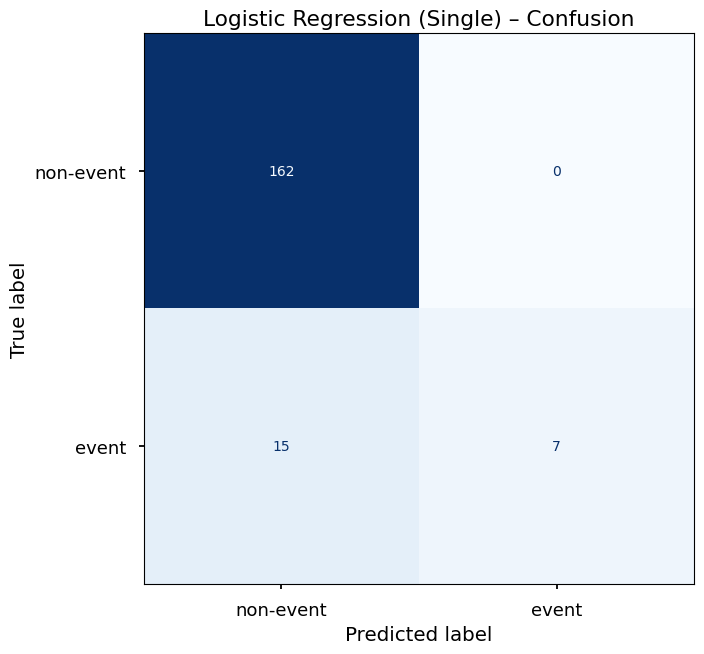

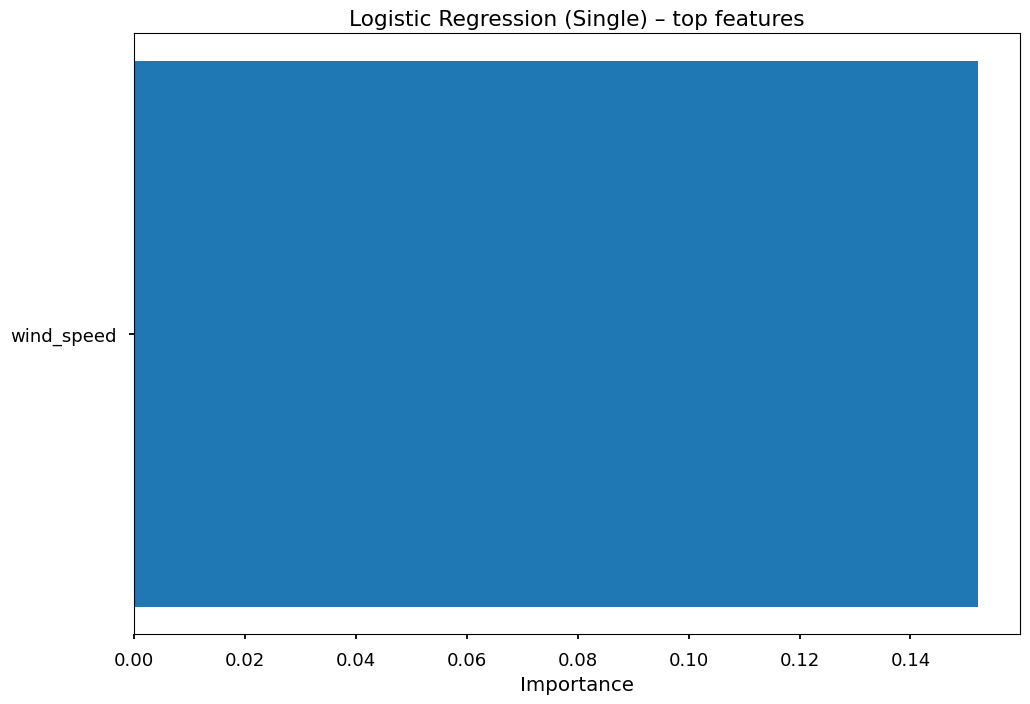

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-20 12:56:19,607] A new study created in memory with name: no-name-965ea6de-1422-4160-8d25-296f22ad0298


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-20 12:56:19,836] Trial 0 finished with value: 0.0 and parameters: {'C': 0.0010532913186523574}. Best is trial 0 with value: 0.0.
[I 2025-06-20 12:56:20,114] Trial 1 finished with value: 0.3447635327635328 and parameters: {'C': 0.5375549132555857}. Best is trial 1 with value: 0.3447635327635328.
[I 2025-06-20 12:56:20,358] Trial 2 finished with value: 0.2328845067975503 and parameters: {'C': 0.03349937592240096}. Best is trial 1 with value: 0.3447635327635328.
[I 2025-06-20 12:56:20,633] Trial 3 finished with value: 0.3813285054664365 and parameters: {'C': 2.208345616817041}. Best is trial 3 with value: 0.3813285054664365.
[I 2025-06-20 12:56:20,938] Trial 4 finished with value: 0.3772325375773652 and parameters: {'C': 67.6331771791551}. Best is trial 3 with value: 0.3813285054664365.
[I 2025-06-20 12:56:21,213] Trial 5 finished with value: 0.3815839333080712 and parameters: {'C': 4.92669622197673}. Best is trial 5 with value: 0.3815839333080712.
[I 2025-06-20 12:56:21,450] T

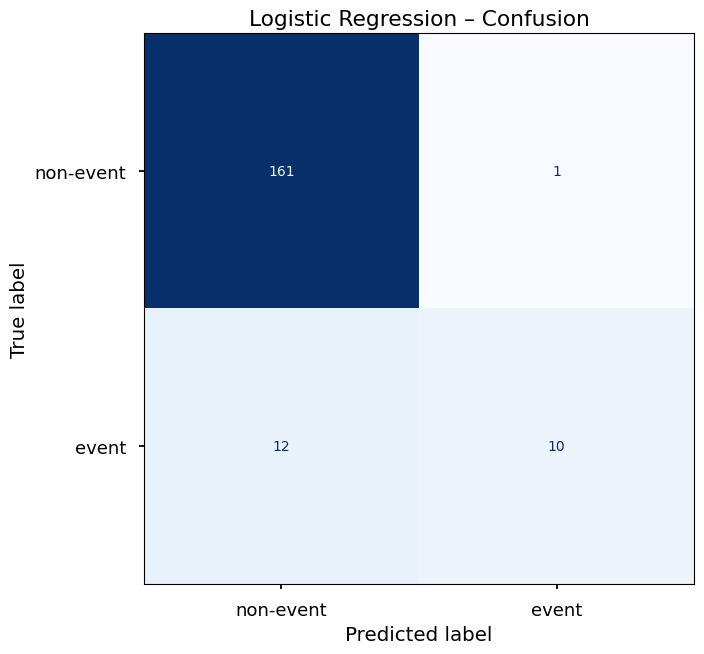

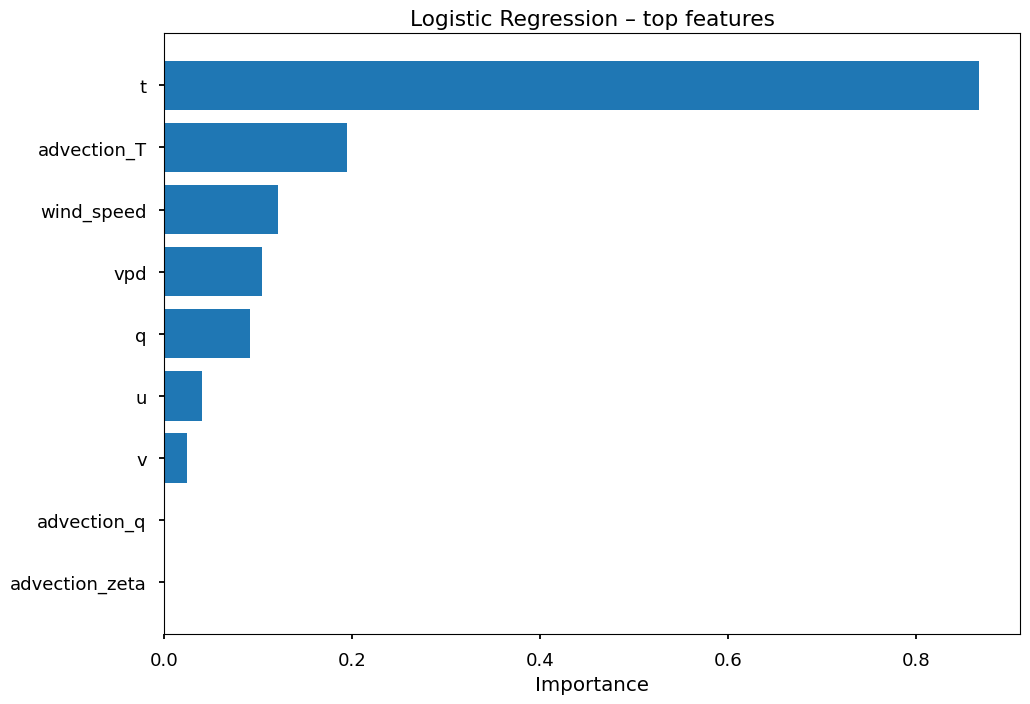

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-20 12:56:32,908] A new study created in memory with name: no-name-724cdd23-13af-41d0-9c1d-68b018fc4bc3


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-20 12:56:38,126] Trial 0 finished with value: 0.5778803472109015 and parameters: {'n_estimators': 180, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.30893214732401025, 'bootstrap': True}. Best is trial 0 with value: 0.5778803472109015.
[I 2025-06-20 12:56:49,831] Trial 1 finished with value: 0.5764319014319015 and parameters: {'n_estimators': 180, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.46892507411440526, 'bootstrap': False}. Best is trial 0 with value: 0.5778803472109015.
[I 2025-06-20 12:56:53,795] Trial 2 finished with value: 0.5340893264897922 and parameters: {'n_estimators': 120, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.4301761400810956, 'bootstrap': True}. Best is trial 0 with value: 0.5778803472109015.
[I 2025-06-20 12:56:58,854] Trial 3 finished with value: 0.6042324787722112 and parameters: {'n_estimators': 120, 'max_depth': 16, 'min_samples_split': 

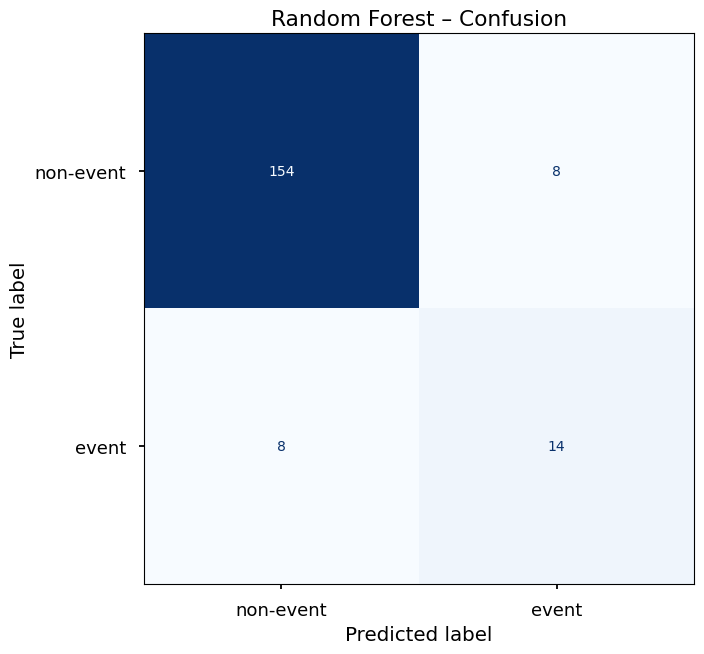

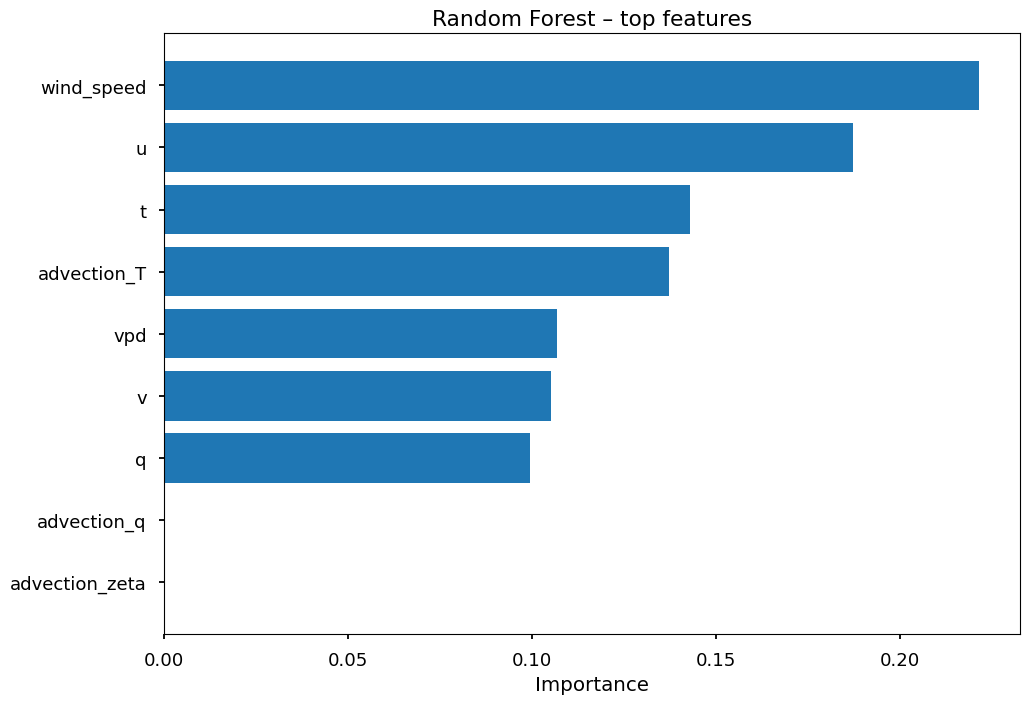

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-20 13:01:39,004] A new study created in memory with name: no-name-b51c1c74-1df4-4317-9d4e-e05df07a2886


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-20 13:01:41,197] Trial 0 finished with value: 0.5849754494717665 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'gamma': 3.4783288903806846, 'subsample': 0.8908585522247698, 'colsample_bytree': 0.7405561199055736, 'learning_rate': 0.08377013604133625, 'n_estimators': 250, 'reg_alpha': 0.23572077243165515, 'reg_lambda': 2.524594793353434, 'scale_pos_weight': 8.09013190804245}. Best is trial 0 with value: 0.5849754494717665.
[I 2025-06-20 13:01:46,317] Trial 1 finished with value: 0.5866843256167531 and parameters: {'max_depth': 11, 'min_child_weight': 7, 'gamma': 2.9412470271817233, 'subsample': 0.8632039025310814, 'colsample_bytree': 0.6577819234963651, 'learning_rate': 0.07743394693496727, 'n_estimators': 550, 'reg_alpha': 0.17097706468474672, 'reg_lambda': 2.7189166775729627, 'scale_pos_weight': 7.579618088818849}. Best is trial 1 with value: 0.5866843256167531.
[I 2025-06-20 13:01:48,841] Trial 2 finished with value: 0.572344640287329 and parameters: {'max_depth'

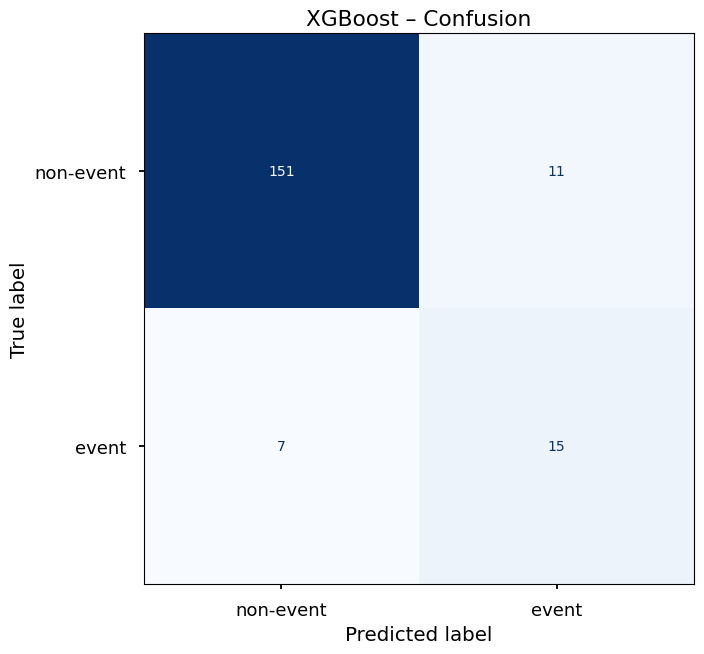

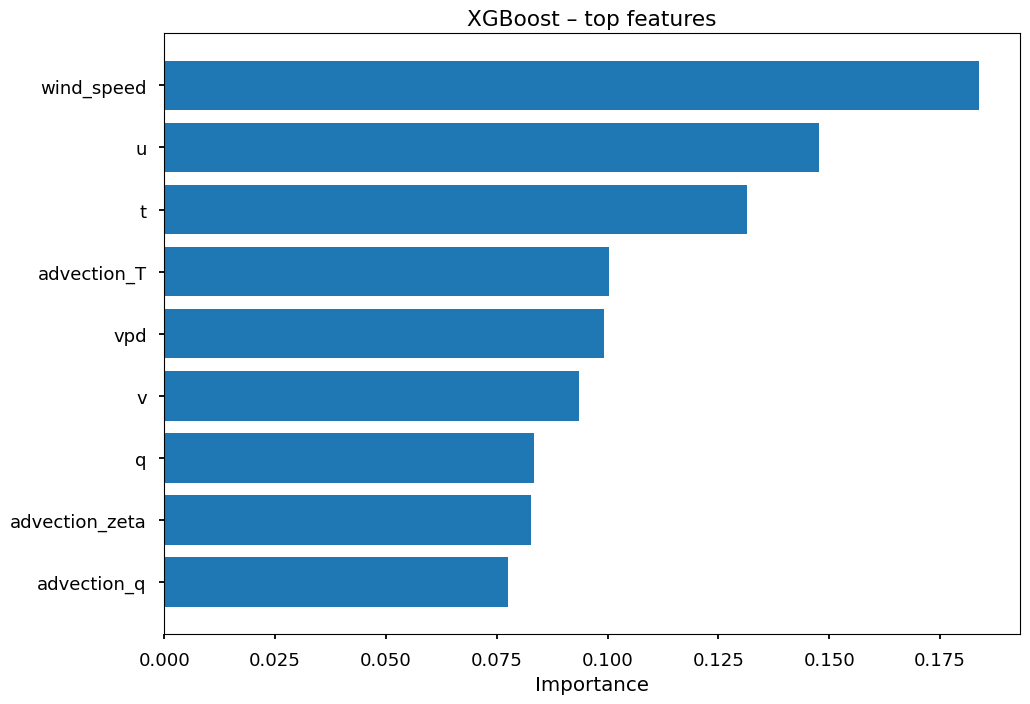

In [69]:
# Define models (no param_grid needed for Optuna)
models = {
    "Logistic Regression (Single)": LogisticRegression(class_weight={0:.1, 1:.9}, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight={0:.1, 1:.9}, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight={0:.1, 1:.9}),
    "XGBoost": XGBClassifier(random_state=42, objective="binary:logistic"),
}

# Train and evaluate each model with Optuna
results = {}

for model_name, model in models.items():
    if model_name == "Logistic Regression (Single)":
        results[model_name] = train_and_evaluate(
            model=model,
            name=model_name,
            X_tr=X_train_single,
            y_tr=y_train_single,
            X_val=X_val_single,
            y_val=y_val_single,
            search="optuna",
            n_trials=50,
            plot=True
        )
    else:
        results[model_name] = train_and_evaluate(
            model=model,
            name=model_name,
            X_tr=X_train,
            y_tr=y_train,
            X_val=X_val,
            y_val=y_val,
            search="optuna",
            n_trials=50,
            plot=True
        )

In [70]:
gc.collect()

15482

## Compare Models

In [86]:
def fit_and_save_model(model, X_train, y_train, model_name):
    """Fit the model and save it to disk."""
    mod = model.fit(X_train, y_train)
    if hasattr(model, "save_model"):  # native XGBoost API
        model.save_model(f"./03_results/models/{model_name}.json")  # saves Booster + params
    else:  # scikit‑learn models
        joblib.dump(model, f"./03_results/models/{model_name}.pkl")  # binary pickle
    return mod

def load_model(model_name):
    """Load a model from disk."""
    if model_name == 'xgb_clf':
        model_path = f"./03_results/models/{model_name}.json"
        if os.path.exists(model_path):
            model = XGBClassifier()
            model.load_model(model_path)
            return model
    else:
        model_path = f"./03_results/models/{model_name}.pkl"
        if os.path.exists(model_path):
            return joblib.load(model_path)
        # If the model is not found, raise an error
        else:
            raise FileNotFoundError(f"Model {model_name} not found at {model_path}")

def make_eval_predictions(model, X_val):
    """Generate predictions and probabilities for evaluation."""
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    return y_pred, y_pred_proba

def produce_ROC_PR_curves(y_val, y_pred_proba):
    """Produce ROC and PR curves along with their metrics."""
    # ROC
    fpr, tpr, _ = metrics.roc_curve(y_val, y_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)

    # PR
    precision, recall, _ = metrics.precision_recall_curve(y_val, y_pred_proba)
    average_precision = metrics.average_precision_score(y_val, y_pred_proba)
    baseline_precision = y_val.sum() / len(y_val)

    return (fpr, tpr, roc_auc), (precision, recall, average_precision, baseline_precision)


In [87]:
Path("models").mkdir(exist_ok=True)

if os.path.exists("./03_results/models/logreg_single.pkl"):
    logreg_single = load_model("logreg_single")
else:
    logreg_single = fit_and_save_model(results['Logistic Regression (Single)']['model'], X_train_single, y_train_single, "logreg_single")

if os.path.exists("./03_results/models/logreg_multi.pkl"):
    logreg_multi = load_model("logreg_multi")
else:
    logreg_multi = fit_and_save_model(results['Logistic Regression']['model'], X_train, y_train, "logreg_multi")

if os.path.exists("./03_results/models/random_forest.pkl"):
    rf = load_model("random_forest")
else:
    rf = fit_and_save_model(results['Random Forest']['model'], X_train, y_train, "random_forest")

if os.path.exists("./03_results/models/xgb_clf.json"):
    xgb = load_model("xgb_clf")
else:
    xgb = fit_and_save_model(results['XGBoost']['model'], X_train, y_train, "xgb_clf")


models = {
    "logreg_single": logreg_single,
    "logreg_multi" : logreg_multi,
    "random_forest": rf,
    "xgb_clf"      : xgb,
    # "best_xgb_clf" : best_xgb,
}

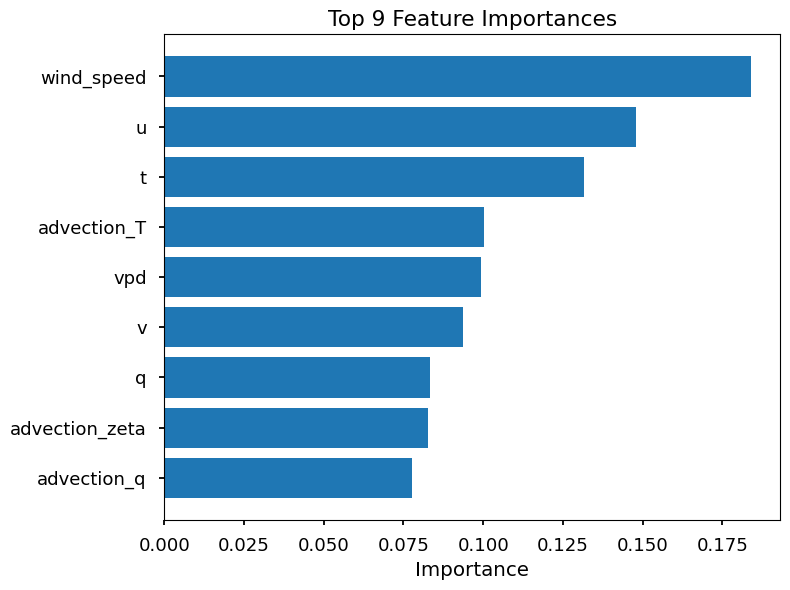

In [88]:
importances = None
if hasattr(xgb, "feature_importances_"):
    importances = xgb.feature_importances_
elif hasattr(xgb, "coef_"):
    importances = np.abs(xgb.coef_.ravel())  # magnitude for LR

if importances is not None:
    # obtain feature names or fallback to generic
    if hasattr(X_train, "columns"):
        feature_names = X_train.columns
    else:
        feature_names = [f"f{i}" for i in range(X_train.shape[1])]

    # sort by importance
    idx_sorted = np.argsort(importances)[::-1]
    top_n = min(20, len(idx_sorted))           # show at most 20 for clarity
    idx_sorted = idx_sorted[:top_n]

    plt.figure(figsize=(8, 6))
    plt.barh(range(top_n), importances[idx_sorted][::-1])
    plt.yticks(range(top_n), np.array(feature_names)[idx_sorted][::-1])
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Feature Importances")
    plt.tight_layout()
    plt.show()

In [89]:
# produce predictions and roc-pr values
models_to_evaluate = {
    "Logistic Regression (Single)": results["Logistic Regression (Single)"]['model'].fit(X_train_single, y_train_single),
    "Logistic Regression": results["Logistic Regression"]['model'].fit(X_train, y_train),
    "Random Forest": results["Random Forest"]['model'].fit(X_train, y_train),
    "XGBoost (Optuna)": results["XGBoost"]['model'].fit(X_train, y_train),
    # "XGBoost (Selected)": best_xgb.fit(X_train, y_train)
}
# Note: If you have a pre-selected XGBoost model, you can uncomment the line
# models_to_evaluate =    {
#     "Logistic Regression (Single)": logreg_single,
#     "Logistic Regression": logreg_multi,
#     "Random Forest": rf,
#     "XGBoost (Optuna)": xgb,
#     # "XGBoost (Selected)": best_xgb
# }
eval_results = {}
for model_name, model in models_to_evaluate.items():
    if model_name == "Logistic Regression (Single)":
        y_pred, y_pred_proba = make_eval_predictions(model, X_val_single)
        (fpr, tpr, roc_auc), (precision, recall, avg_prec, base_prec) = produce_ROC_PR_curves(y_val_single, y_pred_proba)
    else:
        y_pred, y_pred_proba = make_eval_predictions(model, X_val)
        (fpr, tpr, roc_auc), (precision, recall, avg_prec, base_prec) = produce_ROC_PR_curves(y_val, y_pred_proba)

    eval_results[model_name] = {
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba,
        "roc": (fpr, tpr, roc_auc),
        "pr": (precision, recall, avg_prec, base_prec)
    }

### ROC - PR Curves

/tmp/ipykernel_16171/3016203469.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='gray')


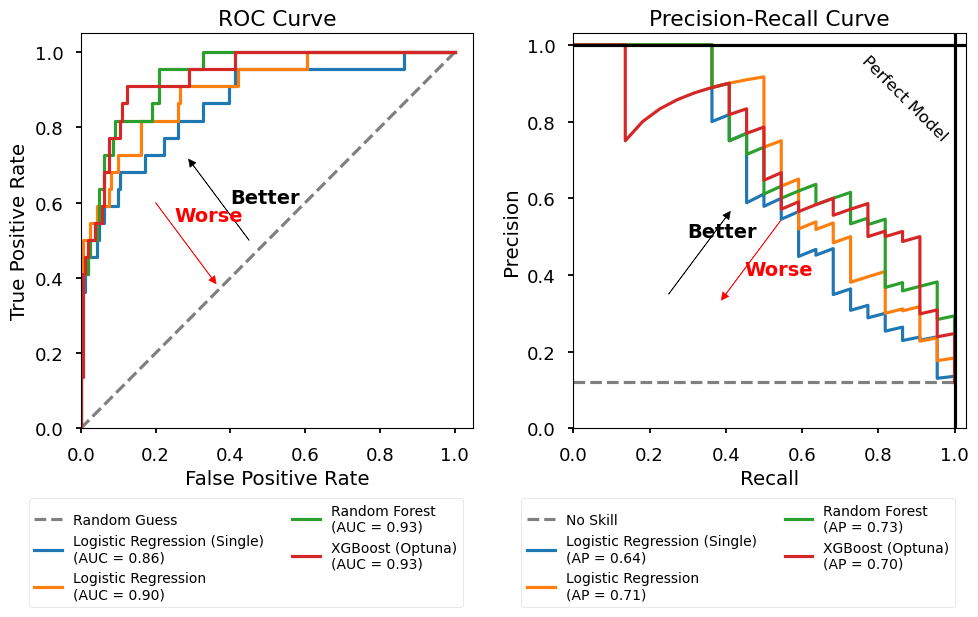

In [90]:
# Plot side-by-side
plt.style.use('seaborn-v0_8-talk')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)

### ROC Plot
ax1.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='gray')
for model_name, res in eval_results.items():
    fpr, tpr, roc_auc = res['roc']
    ax1.plot(fpr, tpr, label=f'{model_name}\n(AUC = {roc_auc:.2f})')
# Inline labels
# ax1.text(0.5, 0.47, 'Random Guess', color='black', fontsize=10, rotation=43)

# Axes and annotations
ax1.set_xlim([0.0, 1.05])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

ax1.text(0.4, 0.6, 'Better', fontsize=14, color='black', fontweight='bold')
ax1.text(0.25, 0.55, 'Worse', fontsize=14, color='red', fontweight='bold')
ax1.arrow(0.2, 0.6, 0.15, -0.2, head_width=0.02, head_length=0.02, fc='red', ec='red')
ax1.arrow(0.45, 0.5, -0.15, 0.2, head_width=0.02, head_length=0.02, fc='black', ec='black')

ax1.legend(loc='lower left', bbox_to_anchor=(-0.15, -0.47), ncol=2, fontsize=10)

### PR Plot
ax2.plot([0, 1], [eval_results[list(eval_results.keys())[0]]['pr'][3]]*2, '--', label='No Skill', color='gray')
for model_name, res in eval_results.items():
    precision, recall, avg_prec, base_prec = res['pr']
    ax2.plot(recall, precision, label=f'{model_name}\n(AP = {avg_prec:.2f})')

# add perfect model lines
ax2.axhline(1, color='black', linestyle='-')
ax2.axvline(1, color='black', linestyle='-')
# Inline labels
ax2.annotate("Perfect Model", xy=(0.75, 0.75), xycoords='data', fontsize=12, color='black', rotation=-45)

ax2.text(0.3, 0.5, 'Better', fontsize=14, color='black', fontweight='bold')
ax2.text(0.45, 0.4, 'Worse', fontsize=14, color='red', fontweight='bold')
ax2.arrow(0.55, 0.55, -0.15, -0.2, head_width=0.02, head_length=0.02, fc='red', ec='red')
ax2.arrow(0.25, 0.35, 0.15, 0.2, head_width=0.02, head_length=0.02, fc='black', ec='black')

# Axes and annotations
ax2.set_xlim([0.0, 1.03])
ax2.set_ylim([0.0, 1.03])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')

ax2.legend(loc='lower left', bbox_to_anchor=(-0.15, -0.47), ncol=2, fontsize=10)

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of the fraction of relevant items among actually returned items while recall is a measure of the fraction of items that were returned among all items that should have been returned. ‘Relevancy’ here refers to items that are postively labeled, i.e., true positives and false negatives.

Precision is defined as the number of true positives over the number of true positives plus the number of false positives.

Recall is defined as the number of true posistives over the number of true positives plus the number of false negatives.

The PR-curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision. High precision is achieved by having few false positives in the returned results, and high recall is obtained by having few false negatives in the relevant results. High scores show that the classifier is returning accurate results and a majority of relevant results. 

A system with high recall but low precision returns most of the relevant items but the proportion of returned results that are incorrectly labeled is high.

### Comparing F1 and Average Precision across models

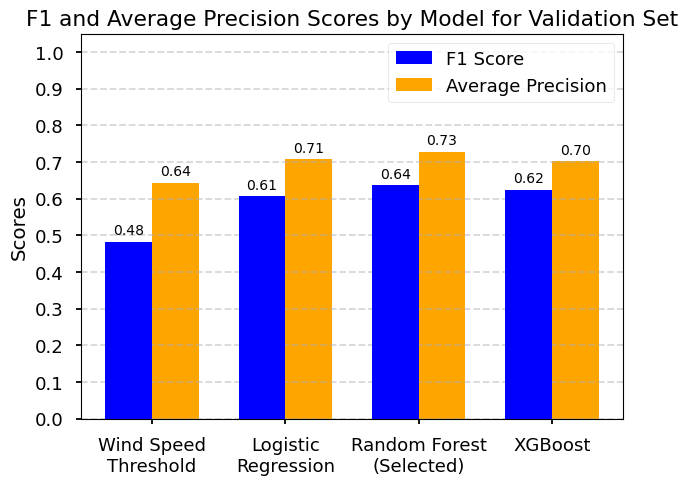

In [218]:
# Validation F1 scores
lr_single_val_f1 = metrics.f1_score(y_val_single, eval_results["Logistic Regression (Single)"]["y_pred"])
lr_val_f1 = metrics.f1_score(y_val, eval_results["Logistic Regression"]["y_pred"])
rf_val_f1 = metrics.f1_score(y_val, eval_results["Random Forest"]["y_pred"])
xgb_val_f1 = metrics.f1_score(y_val, eval_results["XGBoost (Optuna)"]["y_pred"])
# Uncomment if you have the selected XGBoost model
# xgb_best_val_f1 = metrics.f1_score(y_val, eval_results["XGBoost (Selected)"]["y_pred"])


# Validation Average Precision scores
lr_single_val_ap = metrics.average_precision_score(y_val_single, eval_results["Logistic Regression (Single)"]["y_pred_proba"])
lr_val_ap = metrics.average_precision_score(y_val, eval_results["Logistic Regression"]["y_pred_proba"])
rf_val_ap = metrics.average_precision_score(y_val, eval_results["Random Forest"]["y_pred_proba"])
xgb_val_ap = metrics.average_precision_score(y_val, eval_results["XGBoost (Optuna)"]["y_pred_proba"])
# Uncomment if you have the selected XGBoost
# xbg_best_ap = metrics.average_precision_score(y_val, eval_results["XGBoost (Selected)"]["y_pred_proba"])

# offset scores under each label
labels = ['Wind Speed\nThreshold', 'Logistic\nRegression', 'Random Forest\n(Selected)', 'XGBoost']
f1_scores = [lr_single_val_f1, lr_val_f1, rf_val_f1, xgb_val_f1]
ap_scores = [lr_single_val_ap, lr_val_ap, rf_val_ap, xgb_val_ap]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# bar plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=10)
rects1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score', color='blue',
                # add scores above the bars
                zorder=5)
ax.bar_label(rects1, padding=3, fmt='%.2f', fontsize=10, color='black', zorder=5)
rects2 = ax.bar(x + width/2, ap_scores, width, label='Average Precision', color='orange')
ax.bar_label(rects2, padding=3, fmt='%.2f', fontsize=10, color='black', zorder=5)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('F1 and Average Precision Scores by Model for Validation Set')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha='center', va='top')
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.set_ylim(0,1.05)
ax.legend()


In [215]:
gc.collect()

7289

## Selected Model Results

We chose XGBoost. This model will be used.

Can I just use the loaded ds to do this? Why do I need to do this individually?

### Functions

In [92]:
# define function to calculate day of the water year
def get_day_of_water_year(date):
    # if input is type dt.date convert to dt.datetime
    if type(date) == dt.date:
        date = dt.datetime(date.year, date.month, date.day)
    # if the date is before october 1st, subtract one from the year
    if date.month < 10:
        year = date.year - 1
    else:
        year = date.year
    # create a datetime object for october 1st of the year
    oct_1 = dt.datetime(year, 10, 1)
    # calculate the day of water year
    day_of_water_year = (date - oct_1).days + 1
    return day_of_water_year

# ----------------------------------------------------------------------
# 2.  Build the base prediction DataFrame
# ----------------------------------------------------------------------
def build_prediction_df(predictions: np.ndarray,
                        cleaned_df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame with temporal helper columns already attached.
    """
    df = cleaned_df.copy()
    if "valid_time" in df.columns:
        # set index to valid_time
        df.index = pd.to_datetime(df['valid_time'])
        df = df.sort_index()
        # drop the 'valid_time' column
        df = df.drop(columns=['valid_time'])

    # add predictions as a new column
    df['sublimation_event'] = predictions

    df['day_of_water_year'] = df.index.map(get_day_of_water_year)
    df['month'] = df.index.month

    # Water‑year: Oct→Sep
    df['water_year'] = np.where(df.index.month < 10,
                                df.index.year,
                                df.index.year + 1)

    df['decade'] = (df['water_year'] // 10) * 10
    return df

# ----------------------------------------------------------------------
# 3.  Detect long events & annotate the DataFrame
# ----------------------------------------------------------------------
def label_long_events(df: pd.DataFrame,
                      col: str = 'sublimation_event',
                      min_len: int = 4
                      ) -> pd.DataFrame:
    """
    Adds two columns:
        long_event_start : 1 on the first timestep of a long event
        long_event       : 1 on every timestep inside a long event

    Parameters
    ----------
    df : DataFrame with a binary 'col' column
    col : column to search for runs of 1's
    min_len : minimum run length (in rows) to be called a 'long' event
    """
    labeled, _ = label(df[col].values == 1)
    slices = find_objects(labeled)

    df['long_event_start'] = 0
    df['long_event'] = 0

    for lbl, slc in enumerate(slices, start=1):
        if slc is None:
            continue
        run_len = slc[0].stop - slc[0].start
        if run_len >= min_len:
            df.iloc[slc[0].start, df.columns.get_loc('long_event_start')] = 1
            df.iloc[slc[0], df.columns.get_loc('long_event')] = 1
    return df

# ----------------------------------------------------------------------
# 4.  Summarize discrete long‑event counts
# ----------------------------------------------------------------------
def count_long_events(df: pd.DataFrame,
                      group_cols: Tuple[str, ...] = ('decade', 'water_year', 'month')
                      ) -> pd.DataFrame:
    """
    Returns a tidy table with one row per group and the number of
    discrete long events in `number_of_long_events`.
    """
    out = (
        df.groupby(list(group_cols))['long_event_start']
          .sum()
          .rename('number_of_long_events')
          .reset_index()
    )
    return out

### Results

#### Input dataset

<!-- # Apply to timeseries -->

In [ ]:
water_years = np.arange(1980,2026,1)
lat_sel = lat_sel_10_by_10
lon_sel = lon_sel_10_by_10
if not os.path.exists('/storage/dlhogan/data/processed_data/ERA5_reanalysis_western_NA_1980_2025_3H_processed.csv'):
    cleaned_df_list = []

    for water_year in water_years:
        print(f"Opening {water_year} data...")
        winter_slice = slice(f'{water_year-1}-12-01',f'{water_year}-03-31')
        # open reanalysis data
        tmp_wy1_ds = xr.open_dataset(f'/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_{water_year-1}_v2.nc')
        tmp_wy2_ds = xr.open_dataset(f'/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_{water_year}_v2.nc')
        print("Data opened... Performing temporal subset...")
        # temporal subset
        tmp_wy1_subset_ds = subset_ds(tmp_wy1_ds, winter_slice=winter_slice,)
        tmp_wy2_subset_ds = subset_ds(tmp_wy2_ds, winter_slice=winter_slice,)
        print("Temporal subset complete... Performing spatial subset...")
        # spatial subset
        tmp_wy1_subset_winter_ds = spatial_subset(tmp_wy1_subset_ds, lat_sel, lon_sel).mean(dim=['latitude', 'longitude'])
        tmp_wy2_subset_winter_ds = spatial_subset(tmp_wy2_subset_ds, lat_sel, lon_sel).mean(dim=['latitude', 'longitude'])
        print("Spatial subset complete... Merging and cleaning data...")
        combined_df = create_df_combined(tmp_wy1_subset_winter_ds, 
                                        tmp_wy2_subset_winter_ds, 
                                        variables, 
                                        resample=True,
                                        add_events=False) 
        
        print("Data merged and cleaned...")
        cleaned_df_list.append(combined_df)
        
    # merge the cleaned dataframes
    cleaned_df = pd.concat(cleaned_df_list, axis=0)

    # save the cleaned dataframe
    cleaned_df.to_csv('/storage/dlhogan/data/processed_data/ERA5_reanalysis_western_NA_1980_2025_3H_processed.csv', index=False)
    print("Cleaned data saved to /storage/dlhogan/data/processed_data/ERA5_reanalysis_western_NA_1980_2025_3H_processed.csv")
    # close temporary datasets
    gc.collect()
else:
    print("Loading existing cleaned data...")
# load the cleaned dataframe
    cleaned_df = pd.read_csv('/storage/dlhogan/data/processed_data/ERA5_reanalysis_western_NA_1980_2025_3H_processed.csv', index_col=0,  parse_dates=True)
    if "Unnamed: 0" in cleaned_df.columns:
        cleaned_df = cleaned_df.drop(columns=["Unnamed: 0"])

Loading existing cleaned data...


#### Predictions

In [185]:
# predict on this dataframe
predictions = rf.predict(cleaned_df[model_variables])

In [186]:
# 1) Build the full dataframe once
prediction_df = build_prediction_df(predictions, cleaned_df)

# 2) Mark long events (>3 consecutive 3‑h steps = ≥12 h here)
prediction_df = label_long_events(prediction_df, min_len=4)

# 3) Get counts (change group_cols as needed)
long_event_counts = count_long_events(
    prediction_df,
    group_cols=('decade', 'water_year', 'month')
)

# normalize by the number of years in each decade
long_event_counts['number_of_years'] = long_event_counts.groupby('decade')['water_year'].transform('nunique')
long_event_counts['number_of_long_events_per_year'] = (
    long_event_counts['number_of_long_events'] /
    long_event_counts['number_of_years']
)
long_event_counts['month'] = long_event_counts['month'].map(lambda x: 0 if x == 12 else x)


#### Figures

Relationship between primary variable and results

In [211]:
plot_df = prediction_df.groupby('water_year')[['long_event','long_event_start','wind_speed','t']].agg(
    event_hours=('long_event', 'sum'),
    no_of_events=('long_event_start', 'sum'),
    average_wind_speed=('wind_speed', 'mean'),
    average_temperature=('t', 'mean')
)
plot_df['event_hours'] = plot_df['event_hours'] * 3

# add winter precipitation
plot_df['winter_prcp'] = winter_bb_prcp.sum(axis=1).loc[plot_df.index] * 25.4
# multiply event_hours by 3 to convert to hours
predictor, label_1 = "average_wind_speed", "Average Wind Speed (m/s)"   
predictand, label_2 = "event_hours", "Event Hours"

R-squared: 0.29
Spearman correlation: 0.62


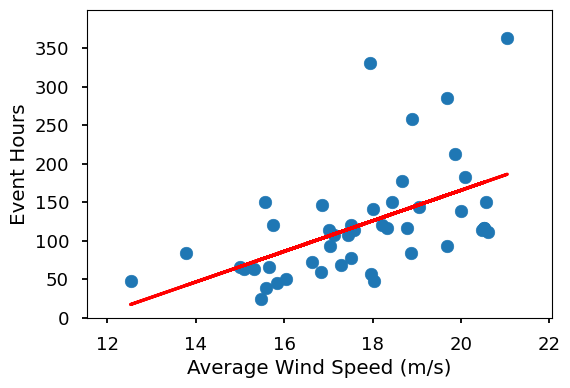

In [212]:
plt.figure(figsize=(6, 4))
plt.scatter(plot_df[predictor], plot_df[predictand])
# add the r2 between variables
slope, intercept, r_value, p_value, std_err = linregress(plot_df[predictor], plot_df[predictand])
plt.plot(plot_df[predictor], intercept + slope * plot_df[predictor], 'r', label='fitted line')
print(f"R-squared: {r_value**2:.2f}")

plt.xlabel(label_1)
plt.ylabel(label_2)
plt.xlim(plot_df[predictor].min()-1, plot_df[predictor].max() + 1)
plt.ylim(0, plot_df[predictand].max() * 1.1)

print(f"Spearman correlation: {plot_df[predictor].corr(plot_df[predictand], method='spearman'):.2f}")

How well does 500-mb mean wind speed predict total winter event hours? It accounts for 51% of the variance.

In [213]:
# multiply event_hours by 3 to convert to hours
predictor, label_1 = "winter_prcp", "Winter Precipitation (mm)"   
predictand, label_2 = "event_hours", "Event Hours"

R-squared: 0.21
Spearman correlation: 0.50


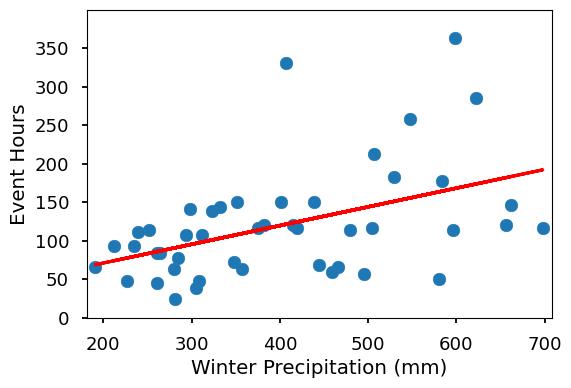

In [214]:
plt.figure(figsize=(6, 4))
plt.scatter(plot_df[predictor], plot_df[predictand])
# add the r2 between variables
slope, intercept, r_value, p_value, std_err = linregress(plot_df[predictor], plot_df[predictand])
plt.plot(plot_df[predictor], intercept + slope * plot_df[predictor], 'r', label='fitted line')
print(f"R-squared: {r_value**2:.2f}")

plt.xlabel(label_1)
plt.ylabel(label_2)
plt.xlim(plot_df[predictor].min()-10, plot_df[predictor].max() + 10)
plt.ylim(0, plot_df[predictand].max() * 1.1)
print(f"Spearman correlation: {plot_df[predictor].corr(plot_df[predictand], method='spearman'):.2f}")

How well does precipitation predict total winter sublimation event hours? It accounts for 25% of the variance. This dataset is fully independent.

##### Time-series plot

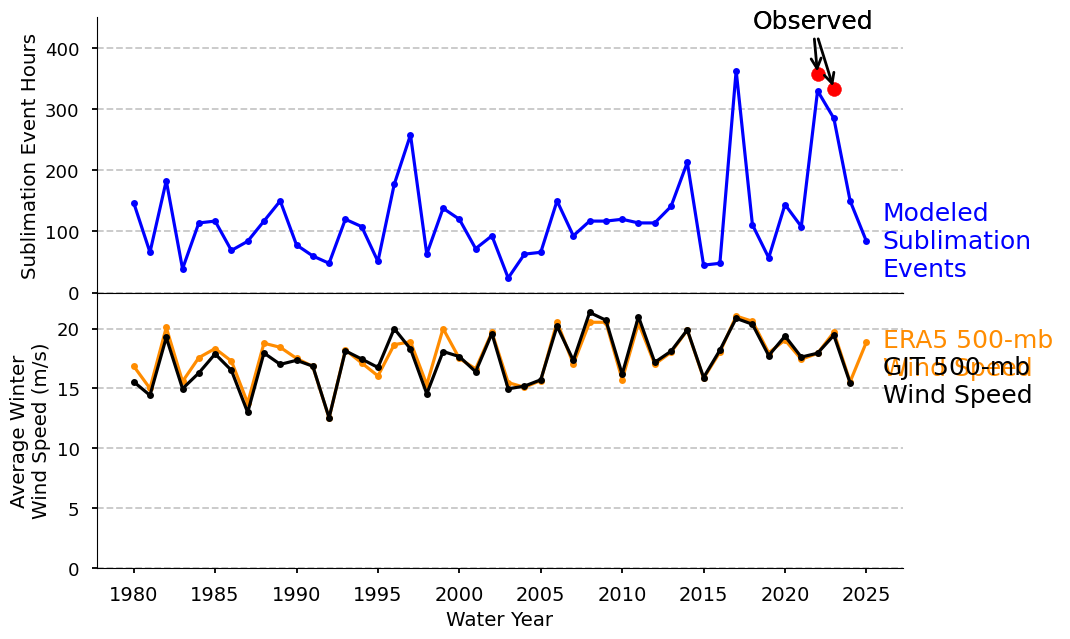

In [191]:
plt.style.use('seaborn-v0_8-talk')

fig = plt.figure()

# set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 2]) 

# the first subplot
ax0 = plt.subplot(gs[0])

ax0.plot(plot_df.index, plot_df['event_hours'], '-o', color='blue', label='Duration of Sublimation Events', markersize=5)
ax0.scatter(x=[2022, 2023],
            y=[len(w22_large_sublimation_long_events)*3, len(w23_large_sublimation_long_events)*3],
            color='red', s=100, label='Observed')
ax0.set_ylabel('Sublimation Event Hours')
# add horizontal grid
ax0.grid(axis='y', linestyle='--', alpha=0.7)
ax0.set_ylim(0,450)

# annotate observed values
ax0.annotate('Observed', xy=(2022, len(w22_large_sublimation_long_events)*3), xytext=(2018, len(w22_large_sublimation_long_events)*3+75),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=18, color='black')
ax0.annotate('Observed', xy=(2023, len(w23_large_sublimation_long_events)*3), xytext=(2018, len(w22_large_sublimation_long_events)*3+75),
                arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=18, color='black')

# annotate the line 
ax0.annotate('Modeled\nSublimation\nEvents', xy=(2024, (plot_df['event_hours']).iloc[-1]), 
             xytext=(2026, (plot_df['event_hours']).iloc[-1]), 
             fontsize=18, 
             va='center',
             color='blue')

# remove top and right spine
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

ax1 = plt.subplot(gs[1], sharex = ax0)  
ax1.plot(plot_df.index, plot_df['average_wind_speed'], '-o', color='darkorange', label='Average Winter 500-mb Wind Speed', markersize=5)
ax1.plot(guc_obs.loc[1980:2024].index, guc_obs.loc[1980:2024]['winds'], '-o', color='black', label='Observed GJT Wind Speed', markersize=5)
ax1.set_xlabel('Water Year')
ax1.set_ylabel('Average Winter\nWind Speed (m/s)')

# annotate the line
ax1.annotate('ERA5 500-mb \nWind Speed', xy=(2024, plot_df['average_wind_speed'].iloc[-1]),
                xytext=(2026, plot_df['average_wind_speed'].iloc[-1]-1), 
                fontsize=18, 
                va='center',
                color='darkorange')
ax1.annotate('GJT 500-mb \nWind Speed', xy=(2024, plot_df['average_wind_speed'].iloc[-2]),
                xytext=(2026, plot_df['average_wind_speed'].iloc[-2]), 
                fontsize=18, 
                va='center',
                color='black')

# add horizontal grid
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0,23)

# remove right spine
ax1.spines['right'].set_visible(False)

# show every 5 years on the x-axis
ax1.set_xticks(np.arange(1980, 2026, 5))
ax1.set_xticklabels(np.arange(1980, 2026, 5), fontsize=14)


# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()

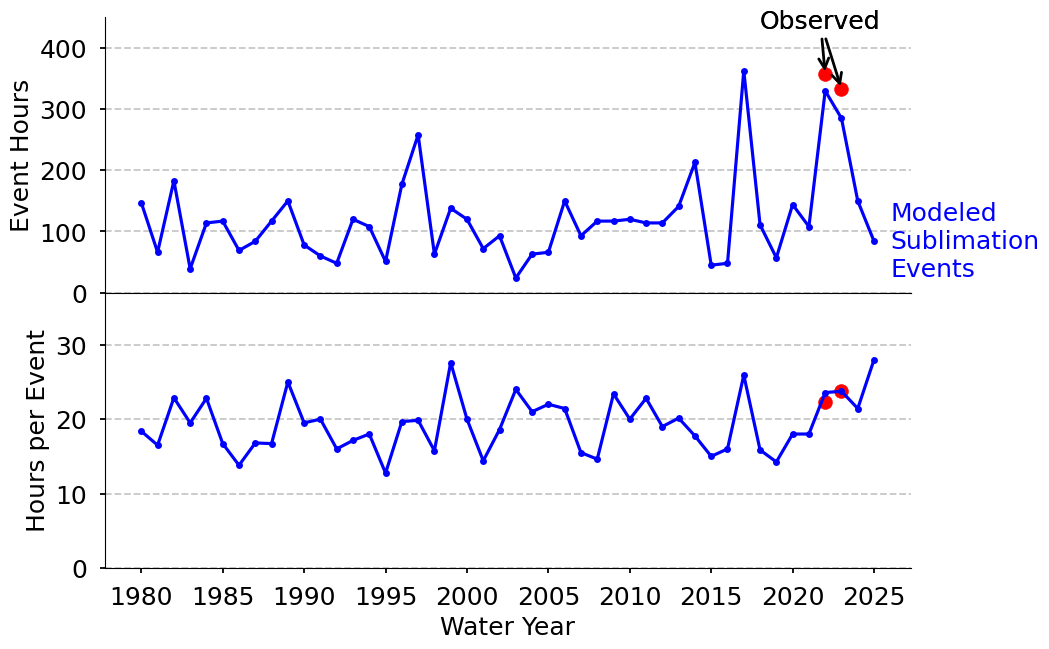

Figure saved to ./04_products/figures/draft/sublimation_event_hours_and_wind_speed.png


In [235]:
plt.style.use('seaborn-v0_8-talk')
plt_font_size = 18  
savefig = True
fig = plt.figure()

# set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 2]) 

# the first subplot
ax0 = plt.subplot(gs[0])

ax0.plot(plot_df.index, plot_df['event_hours'], '-o', color='blue', label='Duration of Sublimation Events', markersize=5)
ax0.scatter(x=[2022, 2023],
            y=[len(w22_large_sublimation_long_events)*3, len(w23_large_sublimation_long_events)*3],
            color='red', s=100, label='Observed')
ax0.set_ylabel('Event Hours', fontsize=plt_font_size)
# add horizontal grid
ax0.grid(axis='y', linestyle='--', alpha=0.7)
ax0.set_ylim(0,450)

# annotate observed values
ax0.annotate('Observed', xy=(2022, len(w22_large_sublimation_long_events)*3), xytext=(2018, len(w22_large_sublimation_long_events)*3+75),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=plt_font_size, color='black')
ax0.annotate('Observed', xy=(2023, len(w23_large_sublimation_long_events)*3), xytext=(2018, len(w22_large_sublimation_long_events)*3+75),
                arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=plt_font_size, color='black')

# annotate the line 
ax0.annotate('Modeled\nSublimation\nEvents', xy=(2024, (plot_df['event_hours']).iloc[-1]), 
             xytext=(2026, (plot_df['event_hours']).iloc[-1]), 
             fontsize=plt_font_size, 
             va='center',
             color='blue')

# remove top and right spine
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

# ytick labels 
ax0.set_yticks(np.arange(0, 401, 100))
ax0.set_yticklabels(np.arange(0, 401, 100), fontsize=plt_font_size)

ax1 = plt.subplot(gs[1], sharex = ax0)  

ax1.plot(plot_df.index, plot_df['event_hours']/plot_df['no_of_events'], '-o', color='blue', label='Duration of Sublimation Events', markersize=5)
ax1.scatter(x=[2022, 2023],
            y=[len(w22_large_sublimation_long_events)*3/16, len(w23_large_sublimation_long_events)*3/14],
            color='red', s=100, label='Observed')
ax1.set_ylabel('Hours per Event', fontsize=plt_font_size)
ax1.set_xlabel('Water Year', fontsize=plt_font_size)

# ytick labels 
ax1.set_yticks(np.arange(0, 37, 10))
ax1.set_yticklabels(np.arange(0, 37, 10), fontsize=plt_font_size)

# add horizontal grid
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0,37)

# annotate observed values
# ax1.annotate('Observed', xy=(2022, len(w22_large_sublimation_long_events)*3/16), xytext=(2018, len(w22_large_sublimation_long_events)*3/16+10),
#              arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=plt_font_size, color='black')
# ax1.annotate('Observed', xy=(2023, len(w23_large_sublimation_long_events)*3/14), xytext=(2018, len(w22_large_sublimation_long_events)*3/16+10),
#                 arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=plt_font_size, color='black')

# # annotate the line 
# ax1.annotate('Modeled\nSublimation\nEvents', xy=(2024, (plot_df['event_hours']/plot_df['no_of_events']).iloc[-1]), 
#              xytext=(2026, (plot_df['event_hours']/plot_df['no_of_events']).iloc[-1]), 
#              fontsize=plt_font_size, 
#              va='center',
#              color='blue')

# remove top and right spine
# ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# show every 5 years on the x-axis
ax1.set_xticks(np.arange(1980, 2026, 5))
ax1.set_xticklabels(np.arange(1980, 2026, 5), fontsize=plt_font_size)


# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()

if savefig:
    fig.savefig('./04_products/figures/draft/sublimation_event_hours.png', dpi=300, bbox_inches='tight')
    print("Figure saved to ./04_products/figures/draft/sublimation_event_hours_and_wind_speed.png")

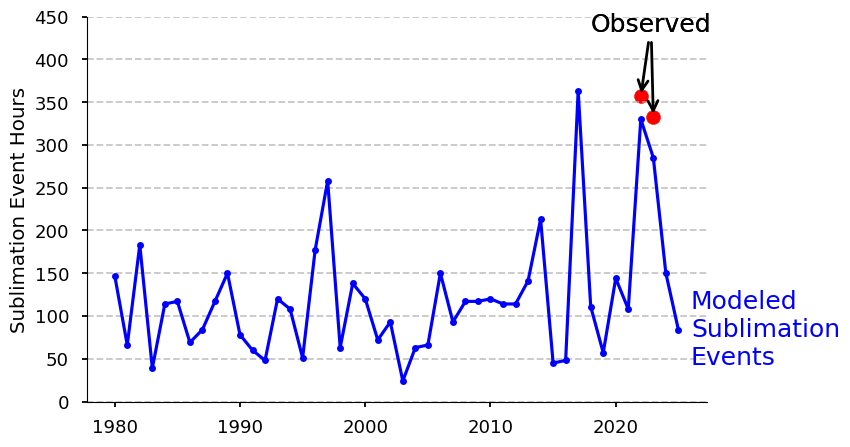

In [192]:
plt.style.use('seaborn-v0_8-talk')

fig = plt.figure(figsize=(8, 5))

# the first subplot
ax0 = plt.subplot()

ax0.plot(plot_df.index, plot_df['event_hours'], '-o', color='blue', label='Duration of Sublimation Events', markersize=5)
ax0.scatter(x=[2022, 2023],
            y=[len(w22_large_sublimation_long_events)*3, len(w23_large_sublimation_long_events)*3],
            color='red', s=100, label='Observed')
ax0.set_ylabel('Sublimation Event Hours')
# add horizontal grid
ax0.grid(axis='y', linestyle='--', alpha=0.7)
ax0.set_ylim(0,450)

# annotate observed values
ax0.annotate('Observed', xy=(2022, len(w22_large_sublimation_long_events)*3), xytext=(2018, len(w22_large_sublimation_long_events)*3+75),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=18, color='black')
ax0.annotate('Observed', xy=(2023, len(w23_large_sublimation_long_events)*3), xytext=(2018, len(w22_large_sublimation_long_events)*3+75),
                arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=18, color='black')

# annotate the line 
ax0.annotate('Modeled\nSublimation\nEvents', xy=(2024, (plot_df['event_hours']).iloc[-1]), 
             xytext=(2026, (plot_df['event_hours']).iloc[-1]), 
             fontsize=18, 
             va='center',
             color='blue')

# remove top and right spine
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)


# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()

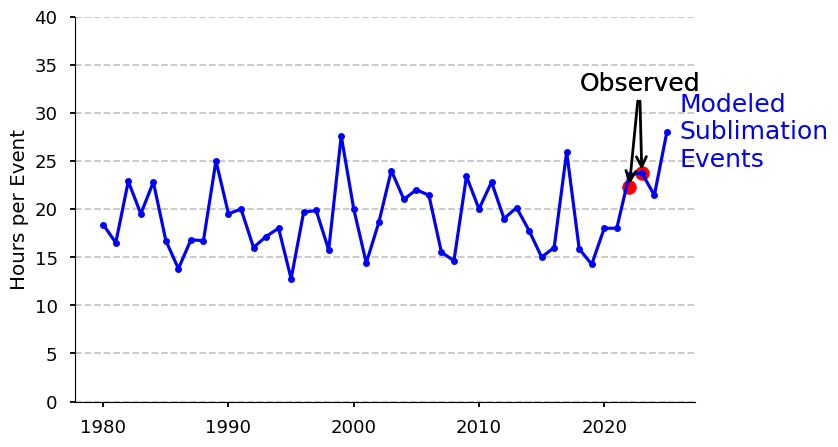

In [195]:
plt.style.use('seaborn-v0_8-talk')

fig = plt.figure(figsize=(8, 5))

# the first subplot
ax0 = plt.subplot()

ax0.plot(plot_df.index, plot_df['event_hours']/plot_df['no_of_events'], '-o', color='blue', label='Duration of Sublimation Events', markersize=5)
ax0.scatter(x=[2022, 2023],
            y=[len(w22_large_sublimation_long_events)*3/16, len(w23_large_sublimation_long_events)*3/14],
            color='red', s=100, label='Observed')
ax0.set_ylabel('Hours per Event')
# add horizontal grid
ax0.grid(axis='y', linestyle='--', alpha=0.7)
ax0.set_ylim(0,40)

# annotate observed values
ax0.annotate('Observed', xy=(2022, len(w22_large_sublimation_long_events)*3/16), xytext=(2018, len(w22_large_sublimation_long_events)*3/16+10),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=18, color='black')
ax0.annotate('Observed', xy=(2023, len(w23_large_sublimation_long_events)*3/14), xytext=(2018, len(w22_large_sublimation_long_events)*3/16+10),
                arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=18, color='black')

# annotate the line 
ax0.annotate('Modeled\nSublimation\nEvents', xy=(2024, (plot_df['event_hours']/plot_df['no_of_events']).iloc[-1]), 
             xytext=(2026, (plot_df['event_hours']/plot_df['no_of_events']).iloc[-1]), 
             fontsize=18, 
             va='center',
             color='blue')

# remove top and right spine
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)


# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()

How many hours (on average) do sublimation events occur each winter? This plot addresses that question.

Follow up question: is there a trend in event hours over time? No significant trend

##### Seasonal Plots

In [247]:
# plot the the mean distribution of long events across decades for each day of each wateryear
mean_long_events = (prediction_df.groupby(['decade', 'month'])['long_event'].sum()).reset_index()
mean_long_events_pivot = mean_long_events.pivot(index='month', columns ='decade', values='long_event')
# replace 12 with 0 for December
mean_long_events_pivot.index = mean_long_events_pivot.index.map(lambda x: 0 if x == 12 else x)
mean_long_events_pivot = mean_long_events_pivot.sort_index()

In [248]:
mean_long_events = prediction_df.groupby(['month','water_year', 'decade'])[['long_event']].agg(
    event_hours=('long_event', 'sum'),
)
mean_long_events['event_hours'] = mean_long_events['event_hours'] * 3
# replace 12 with 0 for December
mean_long_events.index = mean_long_events.index.set_levels(
    mean_long_events.index.levels[0].map(lambda x: 0 if x == 12 else x), level=0
)
mean_long_events = mean_long_events.sort_index()

Text(0, 0.5, 'Event Hours per Month')

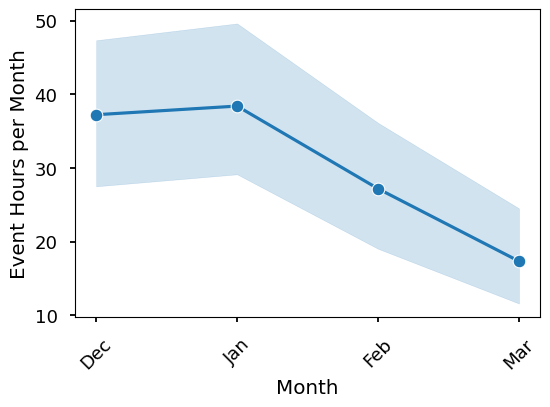

In [249]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=mean_long_events, 
                x='month', 
                y='event_hours', 
                estimator='mean', 
                errorbar=("ci",95),
                marker='o')
# make x-axis month names from December to March
plt.xticks(ticks=np.arange(0, 4, 1), 
           labels=['Dec', 'Jan', 'Feb', 'Mar',], 
           rotation=45)
plt.xlabel("Month")
plt.ylabel("Event Hours per Month")

How many hours (on average) do sublimation events occur each month? This plot addresses that question. Event hours decrease over the winter, peaking in December and dropping to a low in March.

Follow up question: Has there been a change in the number of event hours in each month across decades?

Text(0, 0.5, 'Event Hours per Month')

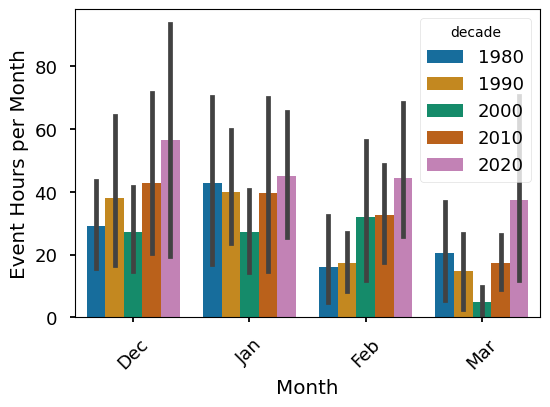

In [250]:
plt.figure(figsize=(6, 4))
sns.barplot(data=mean_long_events, 
                x='month', 
                y='event_hours', 
                estimator='mean', 
                hue='decade',
                palette='colorblind',
                errorbar=("ci",95),
                )
# make x-axis month names from December to March
plt.xticks(ticks=np.arange(0, 4, 1), 
           labels=['Dec', 'Jan', 'Feb', 'Mar',], 
           rotation=45)
plt.xlabel("Month")
plt.ylabel("Event Hours per Month")

Has there been a change in the number of event hours in each month across decades? Recently, they have gotten more uniform. But what is the best way to present this?

In [251]:
# replace month with month names
mean_long_events.index = mean_long_events.index.set_levels(
    mean_long_events.index.levels[0].map(lambda x: 'Dec' if x== 0 else 'Jan' if x == 1 else 'Feb' if x == 2 else 'Mar'), level=0
)

In [252]:
decade_month_long_events = mean_long_events.groupby(['decade','month']).mean()

Text(0, 0.5, 'Event Hours per Month')

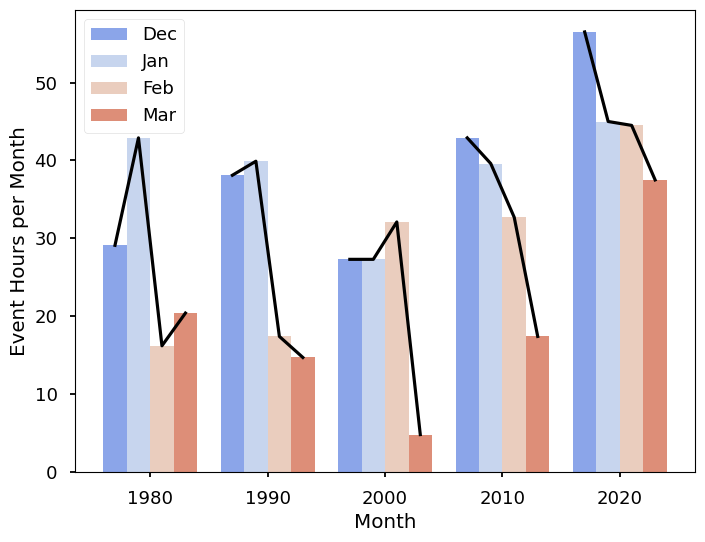

In [253]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(data=mean_long_events, 
                x='decade', 
                y='event_hours', 
                estimator='mean', 
                hue='month',
                palette='coolwarm',
                errorbar=None,
                )
sns.lineplot(x=[-0.3,-0.1,0.1,0.3],
             y=[decade_month_long_events.loc[(1980, 'Dec'), 'event_hours'], 
                decade_month_long_events.loc[(1980, 'Jan'), 'event_hours'], 
                decade_month_long_events.loc[(1980, 'Feb'), 'event_hours'], 
                decade_month_long_events.loc[(1980, 'Mar'), 'event_hours']],
                color='black',
)
sns.lineplot(x=[0.7,0.9,1.1,1.3],
             y=[decade_month_long_events.loc[(1990, 'Dec'), 'event_hours'], 
                decade_month_long_events.loc[(1990, 'Jan'), 'event_hours'], 
                decade_month_long_events.loc[(1990, 'Feb'), 'event_hours'], 
                decade_month_long_events.loc[(1990, 'Mar'), 'event_hours']],
                color='black',
)
sns.lineplot(x=[1.7,1.9,2.1,2.3],
             y=[decade_month_long_events.loc[(2000, 'Dec'), 'event_hours'], 
                decade_month_long_events.loc[(2000, 'Jan'), 'event_hours'], 
                decade_month_long_events.loc[(2000, 'Feb'), 'event_hours'], 
                decade_month_long_events.loc[(2000, 'Mar'), 'event_hours']],
                color='black',
)
sns.lineplot(x=[2.7,2.9,3.1,3.3],
               y=[decade_month_long_events.loc[(2010, 'Dec'), 'event_hours'], 
                  decade_month_long_events.loc[(2010, 'Jan'), 'event_hours'], 
                  decade_month_long_events.loc[(2010, 'Feb'), 'event_hours'], 
                  decade_month_long_events.loc[(2010, 'Mar'), 'event_hours']],
               color='black',
)  
sns.lineplot(x=[3.7,3.9,4.1,4.3],
             y=[decade_month_long_events.loc[(2020, 'Dec'), 'event_hours'], 
                decade_month_long_events.loc[(2020, 'Jan'), 'event_hours'], 
                decade_month_long_events.loc[(2020, 'Feb'), 'event_hours'], 
                decade_month_long_events.loc[(2020, 'Mar'), 'event_hours']],
             color='black',
)

plt.xlabel("Month")
plt.ylabel("Event Hours per Month")

##### Decadal comparison boxplots

Plot the number of long events per winter for each decade

/tmp/ipykernel_16171/4109350057.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0, 0.5, 'Number of Long Events per Winter')

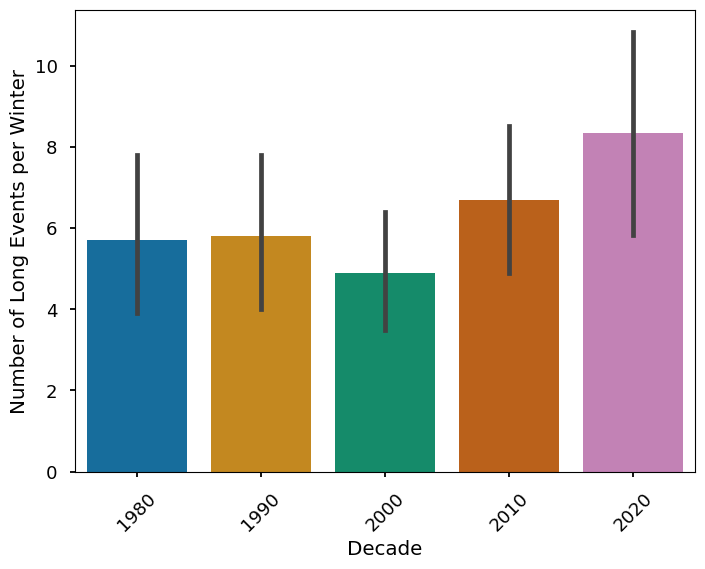

In [254]:
fig = plt.figure(figsize=(8, 6))
# plot a boxplot of the long event counts by month in each decade
sns.barplot(
    data=long_event_counts,
    x="decade",
    y="number_of_long_events_per_year",
    estimator='sum',
    errorbar=('ci', 95),  # 95% confidence interval
    palette="colorblind"
)
plt.xticks(rotation=45)
plt.xlabel("Decade")
plt.ylabel("Number of Long Events per Winter")

How many long events occur per winter. We see somewhere between 10-12 each winter.

/tmp/ipykernel_16171/3172949230.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_long_events*4,


Text(0, 0.5, 'Event Hours per Winter')

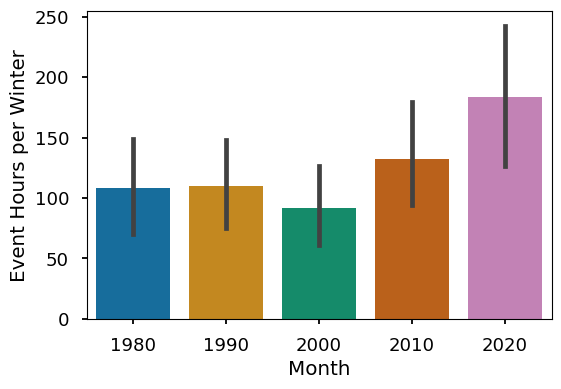

In [255]:
plt.figure(figsize=(6, 4))
sns.barplot(data=mean_long_events*4, 
                x='decade', 
                y='event_hours', 
                estimator='mean', 
                palette='colorblind',
                errorbar=("ci",95),
)

plt.xlabel("Month")
plt.ylabel("Event Hours per Winter")

We see a slight increase over each decade in event hours. 

How have the average length of events changed?

In [256]:
hours_per_event = prediction_df.groupby(['month', 'water_year', 'decade']).agg(
                                        event_hours=('long_event', 'sum'),
                                        long_event_counts=('long_event_start', 'sum')
                                    )
# multiply event_hours by 3 to convert to hours
hours_per_event['event_hours'] = hours_per_event['event_hours'] * 3  # convert to hours

# calculate the average hours per event
hours_per_event['average_hours_per_event'] = (
    hours_per_event['event_hours'] / hours_per_event['long_event_counts']
).fillna(0).round(2)

# replace 12 with 0 for December
hours_per_event.index = hours_per_event.index.set_levels(
    hours_per_event.index.levels[0].map(lambda x: 0 if x == 12 else x), level=0
)

# sort by month
hours_per_event = hours_per_event.sort_index()

hours_per_event.index = hours_per_event.index.set_levels(
    hours_per_event.index.levels[0].map(lambda x: 'Dec' if x== 0 else 'Jan' if x == 1 else 'Feb' if x == 2 else 'Mar'), level=0
)

decade_month_hours_per_event = hours_per_event.groupby(['decade', 'month']).mean()

Figure saved to ./04_products/figures/draft/modeled_sublimation_event_summary.png


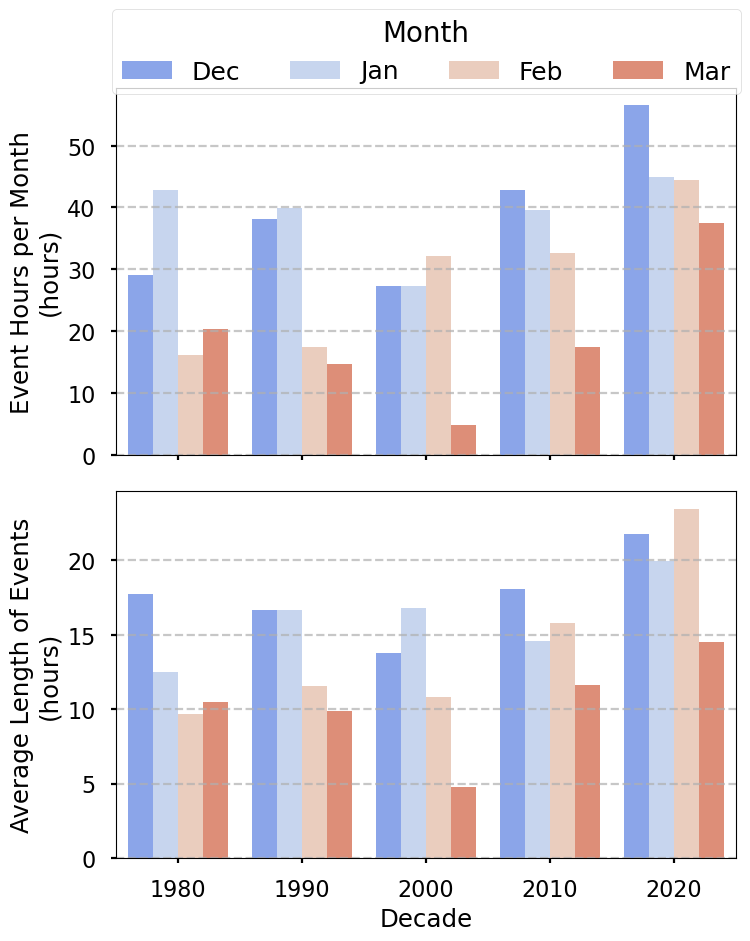

In [279]:
plt.style.use('seaborn-v0_8-poster')
fig, axs = plt.subplots(nrows=2, figsize=(8, 10), sharex=True)
# adjust hspace
fig.subplots_adjust(hspace=0.1)

ax=axs[0]
sns.barplot(ax=ax,
                data=mean_long_events, 
                x='decade', 
                y='event_hours', 
                estimator='mean', 
                hue='month',
                palette='coolwarm',
                errorbar=None,
                )
ax.set_xlabel("Month")
ax.set_ylabel("Event Hours per Month\n(hours)")


ax= axs[1]
sns.barplot(ax=ax,
            data=hours_per_event, 
                x='decade', 
                y='average_hours_per_event', 
                estimator='mean', 
                hue='month',
                palette='coolwarm',
                errorbar=None,
                legend=False,
                )

ax.set_xlabel("Decade")
ax.set_ylabel("Average Length of Events\n(hours)")

# add horizontal grid
for ax in axs:
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # add legend

axs[0].legend(title='Month', 
              title_fontsize=20, 
              loc='center', 
              bbox_to_anchor=(0.5, 1.1), 
              fontsize=18, 
              ncol=4)

savefig = True
if savefig:
    fig.savefig('./04_products/figures/draft/modeled_sublimation_event_summary.png', dpi=300,
                # add some area to the bbox
                bbox_inches='tight', pad_inches=0.1, transparent=True)
    print("Figure saved to ./04_products/figures/draft/modeled_sublimation_event_summary.png")

Follow up question: Do more events occur in some months? Has this distribution changed across decades?

Plot the number of long events per month for each decade

([<matplotlib.axis.XTick at 0x7fbeb21ebbd0>,
 [Text(0, 0, 'Dec'), Text(1, 0, 'Jan'), Text(2, 0, 'Feb'), Text(3, 0, 'Mar')])

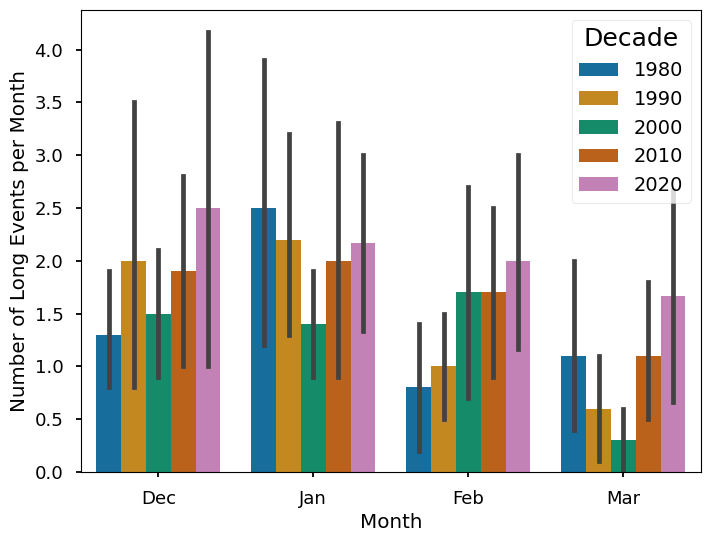

In [243]:
fig = plt.figure(figsize=(8, 6))
# plot a boxplot of the long event counts by month in each decade
sns.barplot(
    data=long_event_counts.map(lambda x: 0 if x == 12 else x),
    x="month",
    y="number_of_long_events_per_year",
    hue="decade",
    palette="colorblind",
    estimator='sum',
    errorbar=("ci",95),
)

plt.legend(title='Decade', bbox_to_anchor=(1.0, 1), loc='upper right', fontsize=14, title_fontsize=18)
plt.xlabel("Month")
plt.ylabel("Number of Long Events per Month")

# change x-axis ticks to month names
plt.xticks(ticks=np.arange(0, 4, 1),
              labels=['Dec', 'Jan', 'Feb', 'Mar'],
                rotation=0, ha='center', va='top')

Do more events occur in some months? Has this distribution changed across decades? Yes, more events occur earlier in the winter. THe 1980s, 1990s, and 2010s showed steady decreases, while the 2000s and 2020s showed more uniform distributions across months.

#### Trend analysis

In [244]:
# perform the Mann-Kendall test
mk_result_no_events = mk.original_test(plot_df['no_of_events'], alpha=0.05)
mk_gjt_obs = mk.original_test(guc_obs['winds'], alpha=0.05)
mk_result_average_windspeed = mk.original_test(plot_df['average_wind_speed'], alpha=0.05)
mk_result_avg_length = mk.original_test(hours_per_event.groupby(['water_year']).mean()['average_hours_per_event'], alpha=0.05)

print(mk_result_no_events)
print(mk_gjt_obs)
print(mk_result_average_windspeed)
print(mk_result_avg_length)


Mann_Kendall_Test(trend='no trend', h=False, p=0.23937745006511513, z=1.176544276804405, Tau=0.11980676328502415, s=124.0, var_s=10929.333333333334, slope=0.03125, intercept=5.296875)
Mann_Kendall_Test(trend='no trend', h=False, p=0.8970134128046536, z=0.12943505283539394, Tau=0.010323010323010324, s=31.0, var_s=53720.333333333336, slope=0.0017944541853143778, intercept=17.759218909858657)
Mann_Kendall_Test(trend='no trend', h=False, p=0.07507390842873574, z=1.7800125403090712, Tau=0.1826086956521739, s=189.0, var_s=11155.0, slope=0.03929045048949767, intercept=16.866074562473973)
Mann_Kendall_Test(trend='increasing', h=True, p=0.011453043659118256, z=2.5285632851474205, Tau=0.2589371980676328, s=268.0, var_s=11150.0, slope=0.15489130434782608, intercept=9.983695652173914)


## Appendix

#### Example figures...
To demonstrate how this cross-validation works

In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5
# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.9]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))

In [ ]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # ax.scatter(
    #     range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    # )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
cvs = [StratifiedShuffleSplit, KFold, StratifiedKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    
    if cv == StratifiedKFold:
        plot_cv_indices(cv(n_splits, shuffle=True, random_state=42), X, y, groups, ax, n_splits)
    else:
        plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

### Model 1: Logistic Regression (Single variable)

In [ ]:
lr_single = LogisticRegression(class_weight='balanced', random_state=42, solver='lbfgs', penalty='l2', C=0.5)
# GridSearchCV parameters to test
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = np.arange(0.01, 0.5, 0.01)

# define the grid
param_grid = {
    # 'solver': solvers,
    # 'penalty': penalty,
    'C': c_values,
}

In [ ]:
# create the gridsearch
grid_search = GridSearchCV(
    estimator=lr_single, # our logistic regression model
    param_grid=param_grid, # the grid of parameters to test
    scoring=scoring, # the scoring metrics to use
    refit = 'F1', # the metric to use to select the best model
    cv=cv, # the cross-validation object
    n_jobs=4, # use 4 cores
    return_train_score=True, # return the training score
)

In [ ]:
# run the model
results_lr = grid_search.fit(X_train_single, y_train_single)
results_lr_cv = results_lr.cv_results_

#### Model Performance

In [ ]:
plt.figure(figsize=(5, 5))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(results_lr_cv[f"param_{list(param_grid.keys())[0]}"]), max(results_lr_cv[f"param_{list(param_grid.keys())[0]}"]))
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results_lr_cv[f"param_{list(param_grid.keys())[0]}"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results_lr_cv["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results_lr_cv["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results_lr_cv["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results_lr_cv["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))
    # Annotate the best parameter for that scorer
    ax.annotate(
        "%s" % round(X_axis[best_index],1),
        (X_axis[best_index], -0.01),
        ha="center",
        va="top",
    )

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [ ]:
print("Best: %f using %s" % (results_lr.best_score_, results_lr.best_params_))
means = results_lr_cv['mean_test_F1']
stds = results_lr_cv['std_test_F1']
params = results_lr_cv['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#### Fit the best model and classify results

In [ ]:
# Fit the model
lr_single_best = LogisticRegression(class_weight='balanced', 
                             random_state=42, 
                             solver='lbfgs', 
                             penalty='l2', 
                             C=0.03).fit(X_train_single, y_train_single)
lr_single_y_pred_proba = lr_single_best.predict_proba(X_val_single)[:, 1]

# ROC
lr_single_fpr, lr_single_tpr, _ = metrics.roc_curve(y_val_single, lr_single_y_pred_proba)
lr_single_roc_auc = metrics.auc(lr_single_fpr, lr_single_tpr)

# PR
lr_single_precision, lr_single_recall, _ = metrics.precision_recall_curve(y_val_single, lr_single_y_pred_proba)
lr_single_average_precision = metrics.average_precision_score(y_val_single, lr_single_y_pred_proba)
lr_single_baseline_precision = y_val_single.sum() / len(y_val_single)

# show confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(lr_single_best, X_val_single, y_val_single, cmap='Blues', colorbar=False, display_labels=['non-event', 'event'])

### Model 2: Multi-variable Logistic Regressor

Some background. Logistic "regression" is a classification algorithm that is used to predict the *probability* of a categorical dependent value. It sounds similar to linear regression in some ways, but it is distinctly different because the dependent and independent variables are not related linearly, instead the linear relationship is between the independent variables and the logit (log of odds) of independent variable, essentially its probability. The method can then be used to predict the probability of occurrence of a binary event utilizing a logit function (like Sigmoid/logistic function)
$$p = \frac{1}{1+e^{-y}}$$

where $y = \Beta_0 +\Beta_1X_1 +\Beta_2X_2 ...+\Beta_nX_n$

Logistic regression uses maximum liklihood estimation approach. MLE is a liklihood maximation method while OLS is a distance-minimizing method. Maximizing the liklihood function determines parameters that are most likely to produce the observed data

Model choices include:
- not standardized (insensitive to magnitude)
- 80/20 train test split for validation
- cross validation on k=10 folds with stratified shuffle split.
- performance is evaluated using f1-score, 

In [ ]:
lr = LogisticRegression(class_weight='balanced', random_state=42, solver='lbfgs', penalty='l2', C=0.5)

In [ ]:
# GridSearchCV parameters to test
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = np.arange(0.01, 0.5, 0.01)

# define the grid
param_grid = {
    # 'solver': solvers,
    # 'penalty': penalty,
    'C': c_values,
}

In [ ]:
# create the gridsearch
grid_search = GridSearchCV(
    estimator=lr, # our logistic regression model
    param_grid=param_grid, # the grid of parameters to test
    scoring=scoring, # the scoring metrics to use
    refit = 'F1', # the metric to use to select the best model
    cv=cv, # the cross-validation object
    n_jobs=4, # use 4 cores
    return_train_score=True, # return the training score
)

In [ ]:
# run the model
results_lr = grid_search.fit(X_train, y_train)
results_lr_cv = results_lr.cv_results_

#### Model Performance

In [ ]:
plt.figure(figsize=(5, 5))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(results_lr_cv[f"param_{list(param_grid.keys())[0]}"]), max(results_lr_cv[f"param_{list(param_grid.keys())[0]}"]))
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results_lr_cv[f"param_{list(param_grid.keys())[0]}"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results_lr_cv["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results_lr_cv["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results_lr_cv["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results_lr_cv["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))
    # Annotate the best parameter for that scorer
    ax.annotate(
        "%s" % round(X_axis[best_index],1),
        (X_axis[best_index], -0.01),
        ha="center",
        va="top",
    )

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [ ]:
print("Best: %f using %s" % (results_lr.best_score_, results_lr.best_params_))
means = results_lr_cv['mean_test_F1']
stds = results_lr_cv['std_test_F1']
params = results_lr_cv['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#### Fit the best model and classify results

In [ ]:
# Fit the model
lr_best = LogisticRegression(class_weight='balanced', 
                             random_state=42, 
                             solver='lbfgs', 
                             penalty='l2', 
                             C=0.03).fit(X_train, y_train)
lr_y_pred_proba = lr_best.predict_proba(X_val)[:, 1]

# ROC
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_val, lr_y_pred_proba)
lr_roc_auc = metrics.auc(lr_fpr, lr_tpr)

# PR
lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_val, lr_y_pred_proba)
lr_average_precision = metrics.average_precision_score(y_val, lr_y_pred_proba)
lr_baseline_precision = y_val.sum() / len(y_val)

# show confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(lr_best, X_val, y_val, cmap='Blues', colorbar=False, display_labels=['non-event', 'event'])

### Model 3: Random Forest Classifier

| Model Type             | max_depth | max_features | n_estimators | min_samples_split | min_samples_leaf | Mean F1-Score |
|------------------------|-----------|---------------|---------------|--------------------|-------------------|----------------|
| Areal Average          | 7         | 3             | 20            | 10                 | —                 | 0.500          |
| Closest Point          | 10        | 4             | 60            | 5                  | 4                 | 0.520          |
| 5-Grid Areal Average   | 10        | 4             | —             | 2                  | 1                 | 0.545 (±0.109) |
| 17×17 Grid             | 15        | 4             | 5             | 2                  | 2                 | 0.589          |


In [ ]:
rf = RandomForestClassifier(random_state=42, 
                            max_depth=15, 
                            max_features=4,
                            n_estimators=30, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            )
run_description=input("Enter a description for the run: ")
# define the grid
param_grid = {
    'n_estimators': [5, 10, 20, 30, 40, 50,100], # number of trees in the forest
    # 'max_depth': [5,7,10,15], # maximum depth of the tree, balances overfitting and underfitting
    # 'min_samples_split': [2, 5, 10,15,20], # minimum number of samples required to split an internal node
    # 'min_samples_leaf': [1, 2, 4, 5, 10, 15, 20], # minimum number of samples required to be at a leaf node
    # 'max_features': [2,3,4,5], # number of features to consider when looking for the best split
}

# scoring metrics
scoring = {"F1":"f1", 
           "Average_Precision":metrics.make_scorer(metrics.average_precision_score),
        #    "Recall":metrics.make_scorer(metrics.recall_score),
        #    "Precision":metrics.make_scorer(metrics.precision_score),
           }

In [ ]:
rf_grid_search = GridSearchCV(
    estimator=rf, # our logistic regression model
    param_grid=param_grid, # the grid of parameters to test
    scoring=scoring, # the scoring metrics to use
    refit = 'F1', # the metric to use to select the best model
    cv=cv, # the cross-validation object
    n_jobs=4, # use 4 cores
    return_train_score=True, # return the training score
)
results_rf = rf_grid_search.fit(X_train, y_train)
results_rf_cv = results_rf.cv_results_

#### Model Performance

In [ ]:
plt.figure(figsize=(5, 5))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel(list(param_grid.keys())[0])
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(results_rf_cv[f"param_{list(param_grid.keys())[0]}"]), max(results_rf_cv[f"param_{list(param_grid.keys())[0]}"]))
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results_rf_cv[f"param_{list(param_grid.keys())[0]}"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k", ]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results_rf_cv["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results_rf_cv["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results_rf_cv["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results_rf_cv["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))
    # Annotate the best parameter for that scorer
    ax.annotate(
        "%s" % round(X_axis[best_index],1),
        (X_axis[best_index], -0.01),
        ha="center",
        va="top",
    )

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [ ]:
print("Best: %f using %s" % (results_rf.best_score_, results_rf.best_params_))
means = results_rf_cv['mean_test_F1']
stds = results_rf_cv['std_test_F1']
params = results_rf_cv['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#### Log model results

In [ ]:
def log_rf_model_run(
    run_description,
    model_type,
    f1_score,
    n_estimators=None,
    max_depth=None,
    min_samples_split=None,
    min_samples_leaf=None,
    max_features=None,
    output_csv="rf_model_run_log.csv"
):
    """
    Logs the summary of a Random Forest model run to a CSV file.

    Parameters:
        run_description (str): Brief explanation of the uniqueness of this model run.
        model_type (str): The general type or configuration name of the model (e.g., 'areal average', 'closest point').
        f1_score (float): The mean F1-score for this model run.
        All other parameters are optional hyperparameters used in the run.
        output_csv (str): Path to the output CSV file (default: "rf_model_run_log.csv").
    """

    row = pd.DataFrame([{
        "run_description": run_description,
        "model_type": model_type,
        "f1_score": f1_score,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features
    }])

    if os.path.exists(output_csv):
        row.to_csv(output_csv, mode='a', header=False, index=False)
    else:
        row.to_csv(output_csv, mode='w', header=True, index=False)

    print(f"✅ Random Forest model run logged successfully to: {output_csv}")


In [ ]:
best_f1_score = results_rf.best_score_
best_params = results_rf.best_params_

if 'n_estimators' not in best_params.keys():
    best_params['n_estimators'] = rf.n_estimators
if 'max_depth' not in best_params.keys():
    best_params['max_depth'] = rf.max_depth
if 'min_samples_split' not in best_params.keys():
    best_params['min_samples_split'] = rf.min_samples_split
if 'min_samples_leaf' not in best_params.keys():
    best_params['min_samples_leaf'] = rf.min_samples_leaf
if 'max_features' not in best_params.keys():
    best_params['max_features'] = rf.max_features

log_rf_model_run(
    run_description=run_description,
    model_type="Areal Average",
    f1_score=best_f1_score,
    n_estimators=best_params.get('n_estimators'),
    max_depth=best_params.get('max_depth'),
    min_samples_split=best_params.get('min_samples_split'),
    min_samples_leaf=best_params.get('min_samples_leaf'),
    max_features=best_params.get('max_features')
)


#### Feature Importance

In [ ]:
important_features = pd.Series(data=results_rf.best_estimator_.feature_importances_,index=data_X.columns)
important_features.sort_values(ascending=False,inplace=True)

# plot
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar')
plt.title('Feature Importance')

#### Fit the best model

In [ ]:
# Fit the model
rf_best = RandomForestClassifier(random_state=42, 
                            n_estimators=best_params.get('n_estimators'),
                            max_depth=best_params.get('max_depth'),
                            min_samples_split=best_params.get('min_samples_split'),
                            min_samples_leaf=best_params.get('min_samples_leaf'),
                            max_features=best_params.get('max_features')
                            ).fit(X_train, y_train)
                                 
rf_y_pred_proba = rf_best.predict_proba(X_val)[:, 1]

# ROC
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_val, rf_y_pred_proba)
rf_roc_auc = metrics.auc(rf_fpr, rf_tpr)

# PR
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_val, rf_y_pred_proba)
rf_average_precision = metrics.average_precision_score(y_val, rf_y_pred_proba)
rf_baseline_precision = y_val.sum() / len(y_val)

# Show confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(rf_best, X_val, y_val, cmap='Blues', colorbar=False, display_labels=['non-event', 'event'])
# print f1 score
print("F1 Score: ", metrics.f1_score(y_val, rf_best.predict(X_val)))
# print average precision score
print(f"AP: {metrics.average_precision_score(y_val, rf_best.predict(X_val))}")

### Model 4: XGBoost Classifier

| Model Type           | n_estimators | learning_rate | max_depth | scale_pos_weight | subsample | Mean F1-Score |
|----------------------|--------------|----------------|-----------|-------------------|------------|----------------|
| Areal Average        | 30           | 0.3            | 7         | 10                | 0.3        | 0.640          |
| Closest Point        | —            | 0.7            | 7         | 5                 | 0.7        | 0.571          |
| 5-Grid Average       | 30           | 0.2            | 10        | 8                 | 0.5        | 0.590          |
| 10-Grid Average      | 60           | 0.1            | 10        | 5                 | 0.7        | 0.610          |
| 20-Grid Average      | —            | 0.2            | 7         | 10                | 0.5        | 0.660          |
| 17×17 Grid           | 80           | 0.5            | 7         | 50                | 0.9        | 0.630          |


In [ ]:
xgb = XGBClassifier(random_state=42, 
                                   n_estimators=30, 
                                   scale_pos_weight=20, 
                                   learning_rate=0.3,
                                   max_depth=7,
                                   subsample= 0.9,
                                   objective="binary:logistic"
                                )
# Add a short description of what makes this run unique
run_description = input("Enter a brief description of this XGBoost model run: ")
model_area = input("Enter the model area (e.g., '10-grid Areal Average', 'Closest Point'): ")

default = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the range of scale_pos_weight ratios to test
ratios = [5, 10, 20, 50, 100]
# define the grid
param_grid = {
    'learning_rate':  [0.1, 0.2, 0.3,0.5,0.7], # st controls the step size at each boosting iteration
   # 'n_estimators': np.arange(10,50,10), # number of trees in the forest
   #  'max_depth': [2,3,5,7,10], # controls the maximum depth of the decision trees used in the model
    'scale_pos_weight': ratios, # controls the balance of positive and negative weights
    'subsample': [0.1,0.3, 0.5, 0.7, 0.9, 1.], # fraction of samples to be used for each tree
}

# scoring metrics
scoring = {"F1":"f1", 
           "Average_Precision":metrics.make_scorer(metrics.average_precision_score),
        #    "Recall":metrics.make_scorer(metrics.recall_score),
        #    "Precision":metrics.make_scorer(metrics.precision_score),
           }

In [ ]:
xgb_grid_search = GridSearchCV(
    estimator=xgb, # our logistic regression model
    param_grid=param_grid, # the grid of parameters to test
    scoring=scoring, # the scoring metrics to use
    refit = 'F1', # the metric to use to select the best model
    cv=cv, # the cross-validation object
    n_jobs=4, # use 4 cores
    return_train_score=True, # return the training score
)
results_xgb = xgb_grid_search.fit(X_train, y_train)
results_xgb_cv = results_xgb.cv_results_



#### Log model results

In [ ]:
def log_model_run(
    run_description,
    model_type,
    f1_score,
    n_estimators=None,
    learning_rate=None,
    max_depth=None,
    scale_pos_weight=None,
    subsample=None,
    min_samples_split=None,
    min_samples_leaf=None,
    max_features=None,
    output_csv="model_run_log.csv"
):
    """
    Logs the summary of a model run to a CSV file.

    Parameters:
        run_description (str): Brief explanation of the uniqueness of this model run.
        model_type (str): The general type or configuration name of the model (e.g., 'areal average', 'closest point').
        f1_score (float): The mean F1-score for this model run.
        All other parameters are optional hyperparameters used in the run.
        output_csv (str): Path to the output CSV file (default: "model_run_log.csv").
    """

    # Build a single-row DataFrame
    row = pd.DataFrame([{
        "run_description": run_description,
        "model_type": model_type,
        "f1_score": f1_score,
        "n_estimators": n_estimators,
        "learning_rate": learning_rate,
        "max_depth": max_depth,
        "scale_pos_weight": scale_pos_weight,
        "subsample": subsample,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features
    }])

    # Append to CSV, creating file if it doesn't exist
    if os.path.exists(output_csv):
        row.to_csv(output_csv, mode='a', header=False, index=False)
    else:
        row.to_csv(output_csv, mode='w', header=True, index=False)

    print(f"✅ Model run logged successfully: {output_csv}")


In [ ]:
# Assuming you've already run a GridSearchCV or RandomizedSearchCV:
best_f1_score = results_xgb.best_score_
best_params = results_xgb.best_params_

if 'n_estimators' not in best_params.keys():
    best_params['n_estimators'] = xgb.n_estimators
if 'learning_rate' not in best_params.keys():
    best_params['learning_rate'] = xgb.learning_rate
if 'max_depth' not in best_params.keys():
    best_params['max_depth'] = xgb.max_depth
if 'scale_pos_weight' not in best_params.keys():
    best_params['scale_pos_weight'] = xgb.scale_pos_weight
if 'subsample' not in best_params.keys():
    best_params['subsample'] = xgb.subsample
if 'max_features' not in best_params.keys():
    best_params['max_features'] = xgb.max_features if hasattr(xgb, 'max_features') else None  # optional; only include if used

# Now call the log function
log_model_run(
    run_description=run_description,
    model_type=model_area,
    f1_score=best_f1_score,
    n_estimators=best_params.get('n_estimators'),
    learning_rate=best_params.get('learning_rate'),
    max_depth=best_params.get('max_depth'),
    scale_pos_weight=best_params.get('scale_pos_weight'),
    subsample=best_params.get('subsample'),
    max_features=best_params.get('max_features')  # optional; only include if used
)


#### Model Performance

In [ ]:
print("Best: %f using %s" % (results_xgb.best_score_, results_xgb.best_params_))
means = results_xgb_cv['mean_test_F1']
stds = results_xgb_cv['std_test_F1']
params = results_xgb_cv['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
if len(param_grid.keys()) == 1:
    # Plot the results for a single parameter grid
    plt.figure(figsize=(5, 5))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

    plt.xlabel(list(param_grid.keys())[0])
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(min(results_xgb_cv[f"param_{list(param_grid.keys())[0]}"]), max(results_xgb_cv[f"param_{list(param_grid.keys())[0]}"]))
    ax.set_ylim(0, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results_xgb_cv[f"param_{list(param_grid.keys())[0]}"].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ["g", "k", ]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results_xgb_cv["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results_xgb_cv["std_%s_%s" % (sample, scorer)]
            ax.fill_between(
                X_axis,
                sample_score_mean - sample_score_std,
                sample_score_mean + sample_score_std,
                alpha=0.1 if sample == "test" else 0,
                color=color,
            )
            ax.plot(
                X_axis,
                sample_score_mean,
                style,
                color=color,
                alpha=1 if sample == "test" else 0.7,
                label="%s (%s)" % (scorer, sample),
            )

        best_index = np.nonzero(results_xgb_cv["rank_test_%s" % scorer] == 1)[0][0]
        best_score = results_xgb_cv["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))
        # Annotate the best parameter for that scorer
        ax.annotate(
            "%s" % round(X_axis[best_index],1),
            (X_axis[best_index], 0.1),
            ha="center",
            va="top",
        )

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

#### Feature Importance

In [ ]:
important_features = pd.Series(data=results_xgb.best_estimator_.feature_importances_,index=data_X.columns)
important_features.sort_values(ascending=False,inplace=True)

# plot
plt.figure(figsize=(5, 5))
important_features.plot(kind='bar')
plt.title('Feature Importance')

#### Fit the best model and classify results

In [ ]:
xgb_best = XGBClassifier(random_state=42, 
               n_estimators=best_params.get('n_estimators'),
               learning_rate=best_params.get('learning_rate'),
               max_depth=best_params.get('max_depth'),
               scale_pos_weight=best_params.get('scale_pos_weight'),
               subsample=best_params.get('subsample'),
               objective="binary:logistic").fit(X_train, y_train)

In [ ]:
# Fit the model 

y_pred_proba = xgb_best.predict_proba(X_val)[:, 1]

# ROC
xgb_fpr, xgb_tpr, _ = metrics.roc_curve(y_val, y_pred_proba)
xgb_roc_auc = metrics.auc(xgb_fpr, xgb_tpr)

# PR
xgb_precision, xgb_recall, _ = metrics.precision_recall_curve(y_val, y_pred_proba)
xgb_average_precision = metrics.average_precision_score(y_val, y_pred_proba)
xgb_baseline_precision = y_val.sum() / len(y_val)

# # Show confusion matrix
# metrics.ConfusionMatrixDisplay.from_estimator(xgb_best, X_val, y_val, cmap='Blues', colorbar=False, display_labels=['non-event', 'event'])
# # print f1 score
# print("F1 Score: ", metrics.f1_score(y_val, xgb_best.predict(X_val)))
# # print average precision score
# print(f"AP: {metrics.average_precision_score(y_val, xgb_best.predict(X_val))}")

### Plot with plotly

In [ ]:
# plotting
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    x=result_df.index,
    y=result_df['no_of_events']*3,
    mode='lines+markers',
    name='Percentage of Events',
    line=dict(color='blue', width=2),   
), secondary_y=False,)
fig.add_trace(go.Scatter(
    x=[2022, 2023],
    y=[len(w22_large_sublimation_long_events)*3, len(w23_large_sublimation_long_events)*3],
    mode='markers',
    name='Observed',
    marker=dict(color='red', size=10)
), secondary_y=False,)  

# add secondary axis with average wind speed
fig.add_trace(go.Scatter(
    x=result_df.index,
    y=result_df['average_wind_speed'],
    mode='lines+markers',
    name='Average Wind Speed',
    line=dict(color='orange', width=2),\
), secondary_y=True,)

fig.update_layout(
    width=1000,
    height=400,
    title='Total Number of Hours with Sublimation Events by Winter',
    xaxis_title='Water Year',
    yaxis_title='Hours',
    yaxis2_title='Average Wind Speed (m/s)',
)